# Who's that butterfly?

**Students:** Yuval Cohen & Inbar Rotshtein

This project aims to develop a robust and accurate system for identifying different species of butterflies from images.

### The Importance of Butterflies and the Problem We're Solving:

Butterflies are not just beautiful; they are vital components of healthy ecosystems. They serve as crucial pollinators, supporting plant reproduction and biodiversity. Furthermore, they are sensitive indicators of environmental change, and tracking their populations provides valuable insights into the health of our natural world.

However, identifying the vast array of butterfly species can be challenging, even for experts. Manual identification is time-consuming and requires specialized knowledge, creating a bottleneck for large-scale ecological studies, conservation efforts, and citizen science initiatives. This difficulty in accurate and efficient identification is the core problem our project addresses.

### The Significance of Our Solution:

Our project offers a powerful solution by using advanced computer vision to automatically identify butterfly species from images. This means we can:

*   **Collect Data Faster:** Quickly and efficiently gather information about butterfly populations, allowing researchers to cover more ground and track changes over time.
*   **Involve More People:** Create tools that allow anyone, from seasoned scientists to nature enthusiasts, to easily identify butterflies and contribute valuable data to conservation efforts.
*   **Boost Conservation:** Provide essential information needed to understand where different butterfly species live, what they need to survive, and how best to protect those that are at risk.
*   **Ensure Reliability:** Build a system that is rigorously tested to make sure its identifications are accurate and trustworthy.

By automating butterfly identification with a reliable system, we make it easier to study and protect these important creatures, contributing to the health of our planet's biodiversity.

### About the Project:

This project explores different machine learning approaches for the challenging task of butterfly species identification from images. We will be comparing the performance of several models to determine the most effective method for this task.

Our project will investigate the following approaches:

1.  **Classic Models on Raw Images:** We will train basic classification models like Logistic Regression and Support Vector Machines (SVM) directly on the raw pixel data of the butterfly images. This will serve as a baseline to understand the performance of simpler models on this complex visual task.

2.  **Convolutional Neural Network (CNN):** We will develop and train a Convolutional Neural Network (CNN) on the raw image data. CNNs are well-suited for image tasks as they can automatically learn hierarchical features from the pixels.

3.  **Fine-tuned CLIP with Classic Classifiers:** We will leverage the power of a pre-trained vision-language model called CLIP. We will fine-tune the image encoder part of CLIP on our butterfly dataset. The fine-tuned CLIP model will then be used to extract rich feature representations (embeddings) for each image. Finally, we will train classic classifiers, including SVM, K-Nearest Neighbors (KNN), and Logistic Regression, on these extracted CLIP embeddings. This approach combines the benefits of powerful pre-trained models with the interpretability and efficiency of classic classifiers.

By comparing these different architectures and approaches, we aim to identify the most accurate and efficient method for identifying butterfly species from images.

### Dataset Description:

The dataset used in this project is sourced from [https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification?select=test](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification?select=test).

It consists of over 6000 images, representing 75 different species (classes) of butterflies.

A notable characteristic of this dataset is the significant variability within the images. The photos can differ widely in terms of:

*   **Angle and Pose:** Butterflies are captured from various angles and in different poses.
*   **Backgrounds:** The images feature diverse backgrounds, ranging from natural environments to staged settings.
*   **Lighting Conditions:** Lighting can vary, impacting the appearance of the butterflies.
*   **Image Quality:** The resolution and clarity of the images are not uniform.
*   **Partial Views and Occlusions:** Some images may only show a part of the butterfly or have parts obscured.

This inherent variability makes the task of accurate identification more challenging and serves as a good test for the robustness of our different modeling approaches.

# Imports

In [ ]:
!pip install open_clip_torch
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.2 MB/s eta 0:00:00


In [ ]:
import os
import csv
import copy
import warnings
from typing import List, Tuple, Dict
from collections import Counter, defaultdict
import random
import time

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight

import os
import torch.optim as optim
from torch.utils.data import  TensorDataset, random_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.nn.functional as F

from concurrent.futures import ThreadPoolExecutor, as_completed
import os, json, hashlib, functools, warnings
from sklearn.linear_model import SGDClassifier
import seaborn as sns

from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')

import open_clip



Mounted at /content/drive


# Configuration


Defining some constants for later usage

In [ ]:
base_path = "/content/drive/MyDrive/ButterflyProject"

CSV_PATH = f"{base_path}/Training_set.csv"
IMG_DIR  = f"{base_path}/train"
UNFREEZE_LAST_BLOCKS = 2
EPOCHS = 15
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_EVAL = 256
LR = 2e-4
WEIGHT_DECAY = 0.05
EARLY_STOP_PATIENCE = 4
LABEL_SMOOTHING = 0.0
MIXED_PRECISION = False
TARGET_HW = (64, 64)
H, W = TARGET_HW
TEST_SIZE = 0.10
VAL_SIZE = 0.10
RANDOM_STATE = 42
N_SPLITS_CV = 5
OPENCLIP_MODEL = "ViT-B-32"
OPENCLIP_PRETRAINED = "openai"
MAX_LEGEND_CLASSES = 25
VALID_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}


### Dataset Loader (what the code does)

`CSVDataset` reads the CSV (filename, label) and loads images from the dataset root. We also expose:
- **Raw image dataset** – for visualization and CNN/CLIP.
- **Flattened pixel dataset** – for fast classic baselines and PCA.

All transforms keep labels aligned and avoid peeking at the test set.


In [ ]:
class CSVDataset(Dataset):
    """(image_tensor, label_idx, label_str, filename)"""
    def __init__(self, csv_path: str, img_root: str, transform=None, label_encoder: LabelEncoder = None):
        if not os.path.isfile(csv_path):
            raise FileNotFoundError(f"CSV not found: {csv_path}")
        df = pd.read_csv(csv_path)
        if "filename" not in df.columns or "label" not in df.columns:
            raise ValueError("CSV must contain columns: 'filename' and 'label'")

        self.files: List[str] = []
        self.labels_str: List[str] = []
        self.names: List[str] = []
        missing = 0

        for fn, lb in zip(df["filename"].astype(str), df["label"].astype(str)):
            path = os.path.join(img_root, fn)
            if os.path.isfile(path) and os.path.splitext(fn)[1].lower() in VALID_EXT:
                self.files.append(path)
                self.labels_str.append(lb)
                self.names.append(fn)
            else:
                missing += 1

        if missing > 0:
            warnings.warn(f"{missing} file(s) from CSV were missing/invalid and were skipped.")

        if not self.files:
            raise FileNotFoundError(f"No valid images found under {img_root} matching {csv_path}")

        self.transform = transform
        self.le = label_encoder or LabelEncoder().fit(self.labels_str)
        self.labels_idx = self.le.transform(self.labels_str)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, int(self.labels_idx[idx]), self.labels_str[idx], self.names[idx]


## Exploring the Data

We first look at:
- **Class balance** – are species frequencies similar?
- **A quick gallery** – random samples per class to spot artifacts.
- **Prototype images** – average image per class to see coarse visual patterns.


Firstly, we create two datasets - a raw image dataset, and a dataset featuring each image as an equal-length vector of pixels. We do so for the prediction phase later on.

In [ ]:
def pil_to_flat_np(img: Image.Image, size: Tuple[int, int] = TARGET_HW) -> np.ndarray:
    # Resize to HxWx3, convert to float32 in [0,1], then flatten to 1D
    arr = np.asarray(img.resize(size, Image.BILINEAR), dtype=np.float32) / 255.0
    return arr.reshape(-1)

# Build a dataset that outputs flattened pixel vectors
pixel_ds = CSVDataset(
    CSV_PATH,
    IMG_DIR,
    transform=lambda im: pil_to_flat_np(im),   # returns np.ndarray (1D)
)

class_names = list(pixel_ds.le.classes_)

# Build a second dataset, containing the non-flattened images, used for plotting
img_ds = CSVDataset(
    CSV_PATH,
    IMG_DIR,
    transform=None,
)


### Class Balance

The distribution is reasonably balanced for a 75-class set (largest vs. smallest classes are not orders of magnitude apart). Still, we report **macro-F1** to avoid over-favoring common classes.


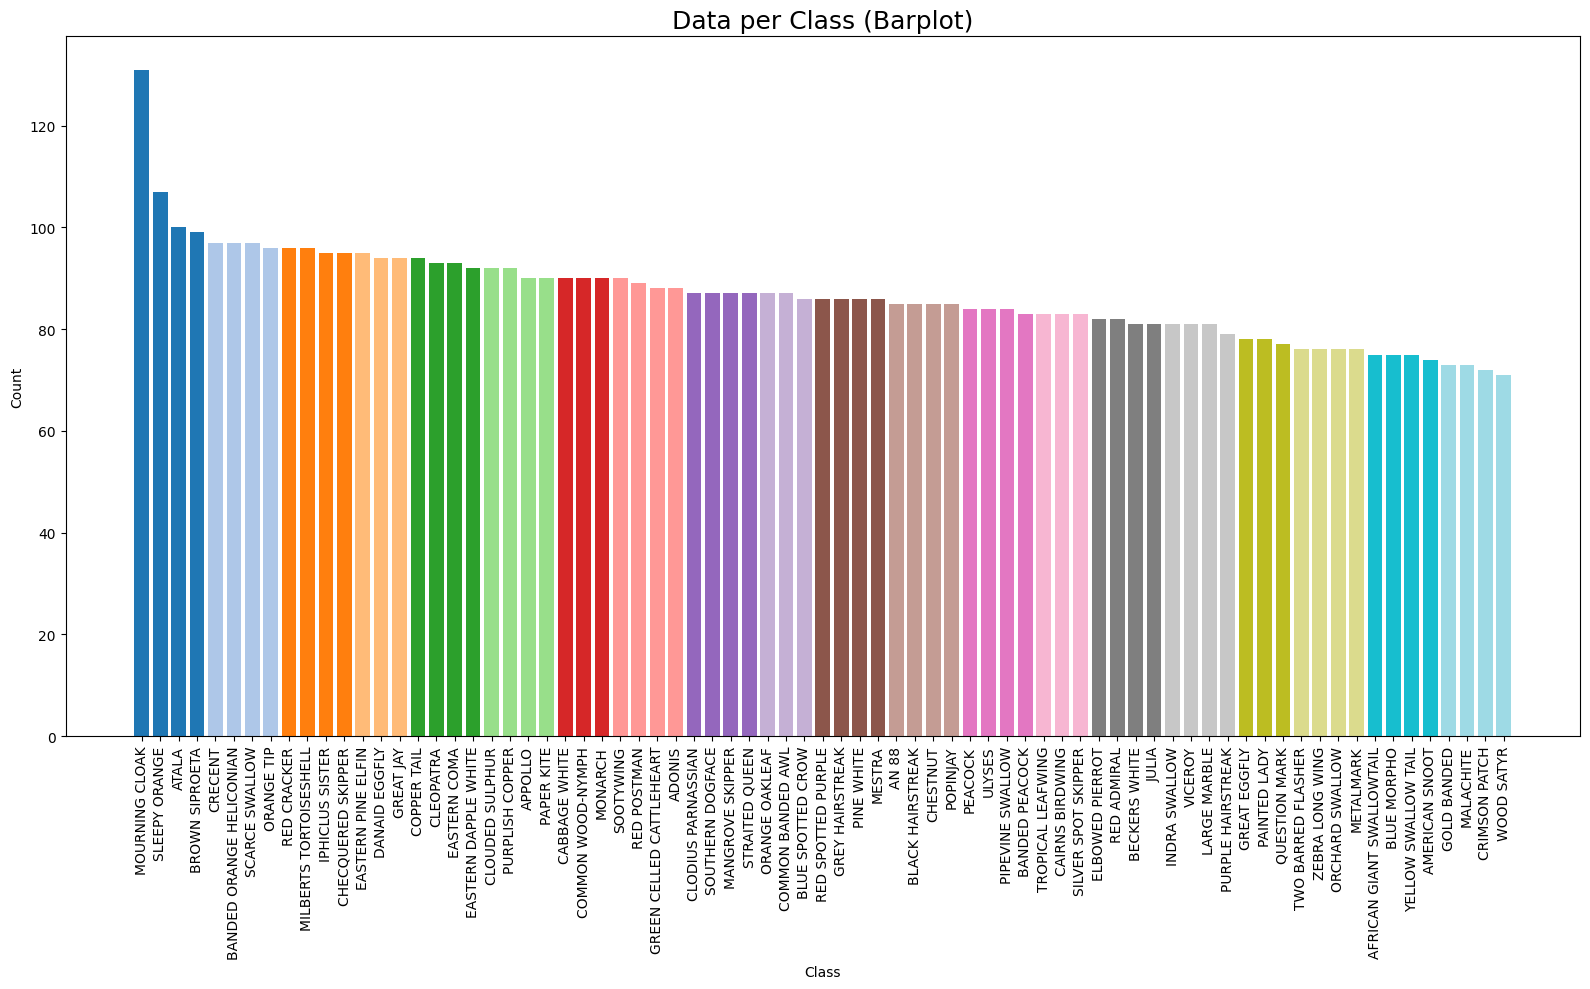

In [ ]:
dataset = pixel_ds
df_counts = pd.DataFrame({
    "label": dataset.labels_str
}).value_counts().reset_index(name="count")

labels = df_counts["label"].tolist()
sizes = df_counts["count"].tolist()

label_texts = [f"{l}\n{c}" for l, c in zip(labels, sizes)]

fig, ax = plt.subplots(figsize=(16, 10))

# Generate distinct colors
colors = plt.cm.tab20(np.linspace(0, 1, len(labels)))  # up to 20 unique, cycles if >20
_ = ax.bar(labels, sizes, color=colors)

ax.set_title("Data per Class (Barplot)", fontsize=18)
ax.set_ylabel("Count")
ax.set_xlabel("Class")

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The data itself is fairly balanced, in the sense that the difference between the largest class to the smallest class is less than 2x, thus it won't bias the models heavily.

### Quick Gallery

Below: a small random grid of images with labels. We look for obvious issues (mislabels, heavy blur, unusual crops). Nothing alarming stands out.


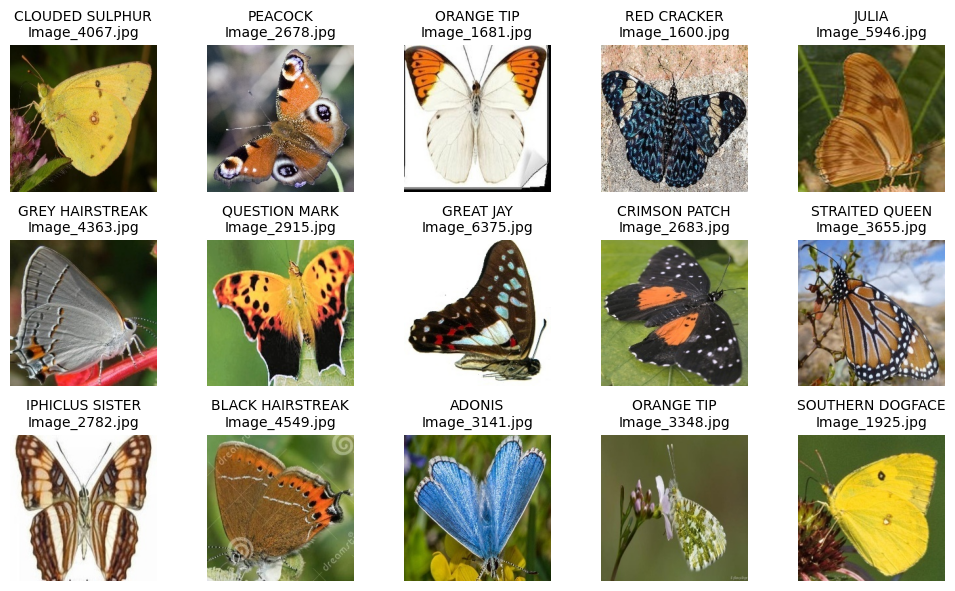

In [ ]:
num_samples = 15
cols = 5
rows = num_samples // cols + (num_samples % cols > 0)

indices = random.sample(range(len(img_ds)), num_samples)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for ax, idx in zip(axes, indices):
  img, _, label, fname = img_ds[idx]
  ax.imshow(img)
  ax.set_title(f"{label}\n{fname}", fontsize=10)
  ax.axis("off")

plt.tight_layout()
plt.show()

Due to the great number of classes, and poor understanding of butterfly species, it's fair to assume an average person would not classify each butterfly correctly. In addition, some images are somewhat blurry, or the color/pattern of the butterfly collides with the background of the image, making it all the more difficult to classify.

We want to find out which classes look visually similar. Let's first group images by classes:

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import math

class_counts = Counter(pixel_ds.labels_str)
class_imgs = {
    label: np.zeros((count, TARGET_HW[0], TARGET_HW[1], 3), dtype=np.float32)
    for label, count in class_counts.items()
}
fill_pos = defaultdict(int)

for x, _, label, _ in pixel_ds:
  pos = fill_pos[label]
  class_imgs[label][pos] = x.reshape(TARGET_HW[0], TARGET_HW[1], 3)
  fill_pos[label] += 1

Secondly, we want to compute an average image per class:

In [ ]:
avg_images = {}
for label, imgs in class_imgs.items():
  avg_images[label] = np.mean(imgs, axis=0)

labels = list(avg_images.keys())

We want to see the average image per class, let's plot a grid of the averages:

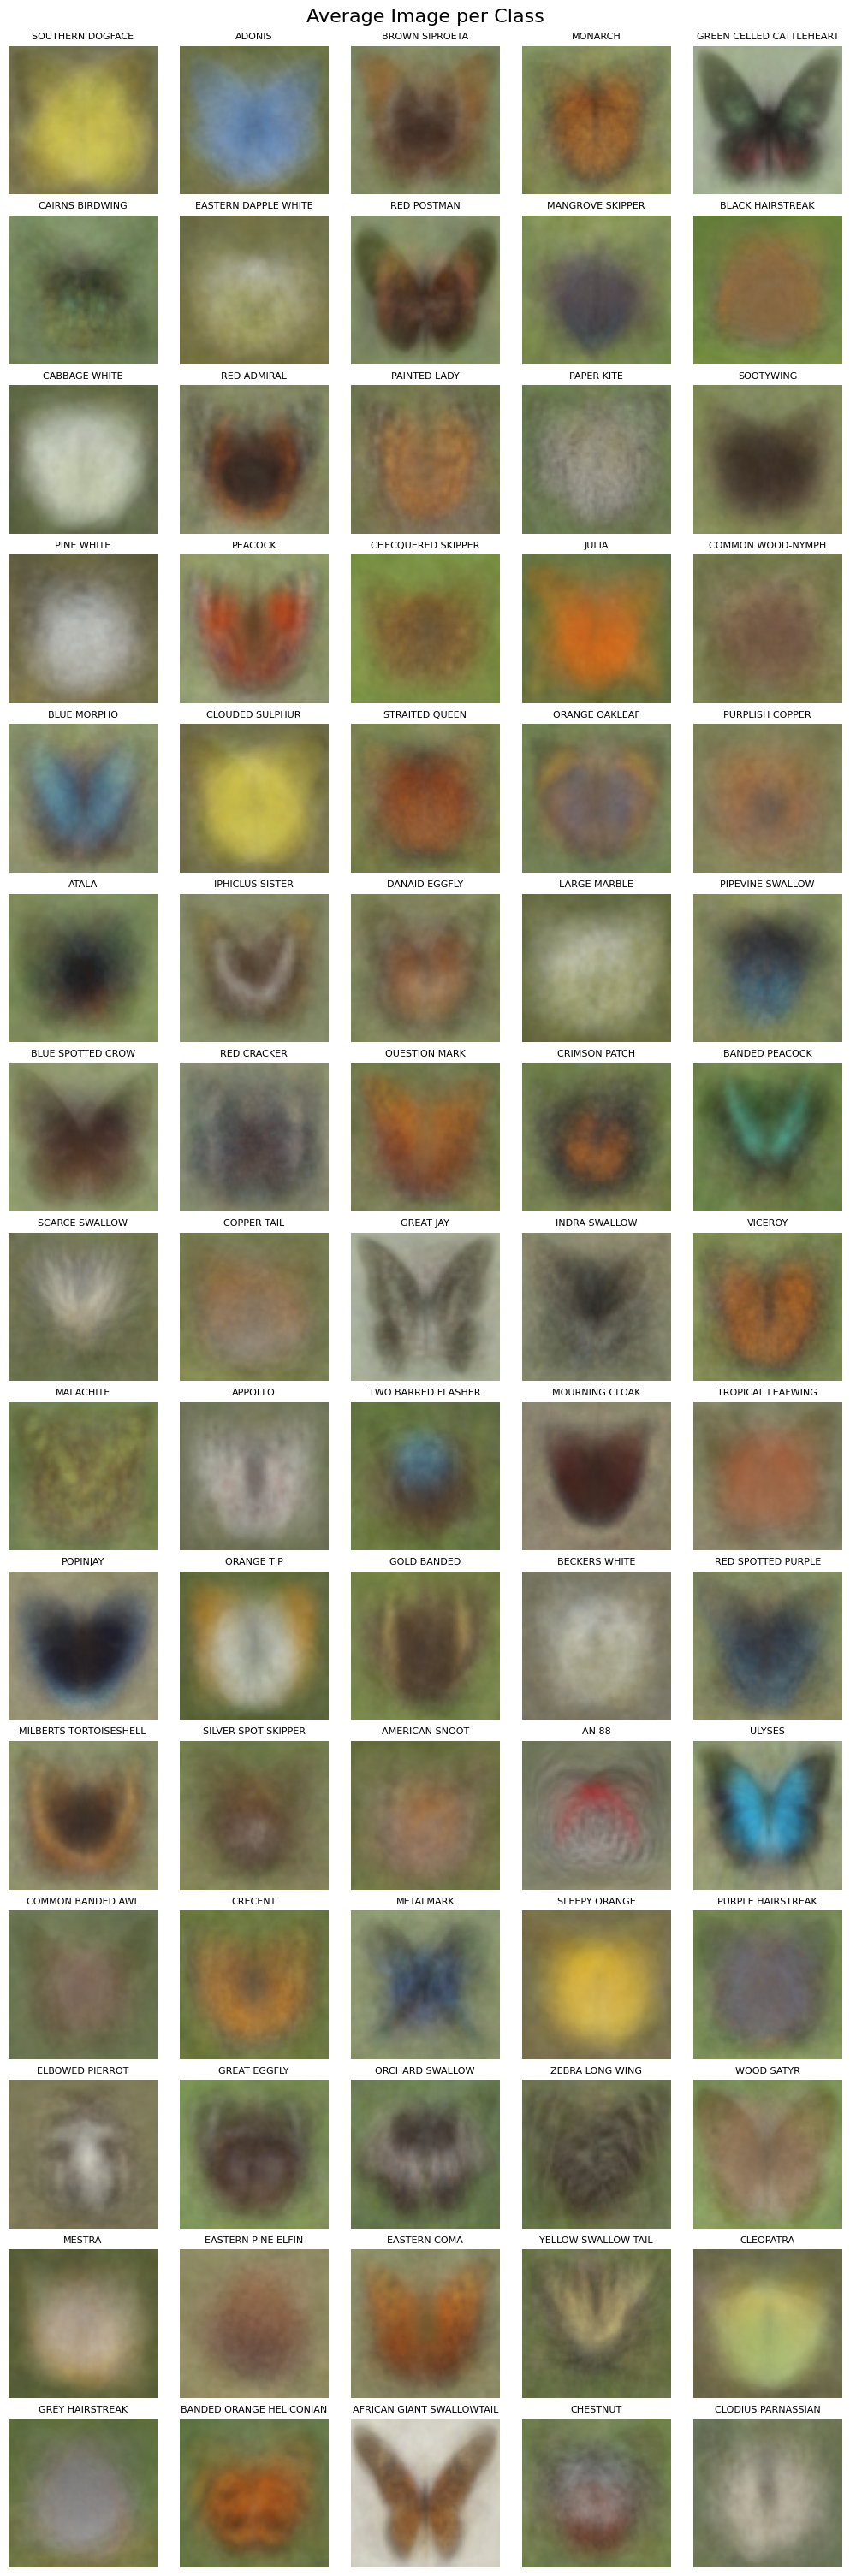

In [ ]:
n_classes = len(labels)
cols = 5
rows = math.ceil(n_classes / cols)

plt.figure(figsize=(10, 2*rows), constrained_layout=True)
for i, label in enumerate(labels):
  plt.subplot(rows, cols, i+1)
  plt.imshow(avg_images[label])
  plt.title(label, fontsize=8)
  plt.axis("off")

plt.suptitle("Average Image per Class", fontsize=16)
plt.show()

We flatten each average image:

In [ ]:
flattened_vecs = np.array([avg_images[label].flatten() for label in labels])

## Hierarchical Clustering:

Now, we will use the method "linkage" to perform hierarchical clustering:

In [ ]:
C = linkage(flattened_vecs, method='ward')

And lastly, we illustrate the clusters:

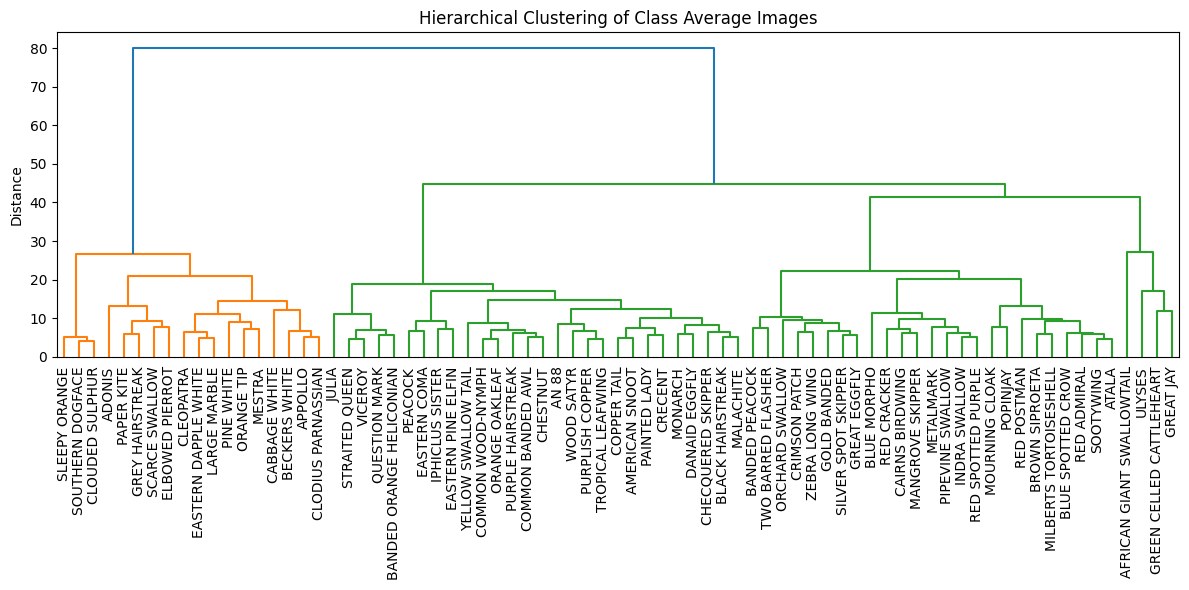

In [ ]:
plt.figure(figsize=(12, 6))
dendrogram(C, labels=labels, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering of Class Average Images")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

The smaller the distance the more similar the classes are, on average. This gives us possible points of confusion for training the models later on.

Let's look for example on the average image for the class "SOUTHERN DOGFACE":

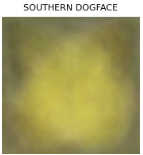


Now, the average image of the class "CLOUDED SULPHUR":

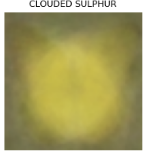

We'll start by prefacing that the images are fairly blurry, as expected, because they are created by averaging approximately 100 images, each containing a different background, a different angle, etc.

However, just by looking at both images with the naked eye, we can tell those are quite similar, and we see they are quite similar in the hierarchical clustering above as well. We can also notice that after the averaging, most images now contain a similar background, meaning the after the averaging we look further into the features of each butterfly, rather than combine it with the environment.

## K-Means Clustering:

We'll group classes into k clusters and visualize the clusters with colors on a scatter plot.

First we'll reduce to 2D, for visualization:

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=50)
avg_reduced = pca.fit_transform(flattened_vecs)
avg_2d = PCA(n_components=2).fit_transform(avg_reduced)

Then we group the classes into 8 clusters. k=8 was chosen for a better understanding of similarity between classes

In [ ]:
k = 8
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(avg_reduced)

And lastly we'll plot the clusters:

In [ ]:
!pip install adjustText

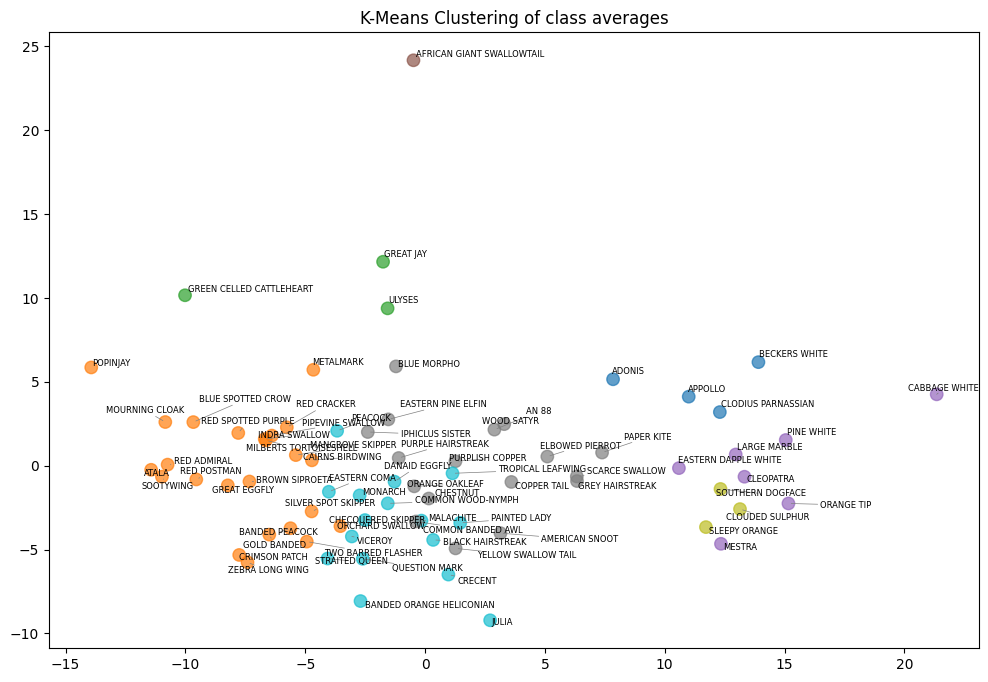

In [ ]:
from adjustText import adjust_text

plt.figure(figsize=(12, 8))
plt.scatter(avg_2d[:,0], avg_2d[:,1], c=clusters, cmap="tab10", s=80, alpha=0.7)

texts = []
for i, label in enumerate(labels):
  texts.append(plt.text(avg_2d[i,0], avg_2d[i,1], label, fontsize=6))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.title("K-Means Clustering of class averages")
plt.show()

This plot is a bit confusing and all over the place, so here's a breakdown:



*   Each dot represents a class, corresponding to the title above it.
*   The X and Y axes don't correspond directly to the images, but they represent directions of variance in the data, since we reduced the data into two components using PCA.
*   Classes closer to eachother in the plot correspond to higher average image similarity.
*   Different classes are grouped in the same cluster if they share the same color. The groups are chosen by the K-Means, based on similarity in the pixel space.

As we can notice many orange-labeled classes are close to eachother, meaning K-Means thinks their average images look similar. Contrary to that, "African Giant Swallowtail" is at the very top, distant from all other classes, meaning it was clustered as dissimilar to all others.

Furthermore, some clusters (orange, cyan and gray) are very compact, which means K-Means thought they have lots of visually similar features. The green cluster, for example, is less dense and compact, meaning it's less cohesive and noticabely similar to K-Means.


**Conclusion:**

From both clustering plots we can tell the class "African Giant Swallowtail" is visually unique, whilst some classes, like "AN 88" and "WOOD SATYR", are very close in both and thus are quite similar visually.

## PCA (for classic baselines)

We standardize pixel vectors, run PCA, and keep components that explain most variance. Classic models (SVM/LogReg/RandomForest) are trained on **train PCA** features and evaluated on the **held-out test** set.


[Data] X: (6499, 12288), y: (6499,), classes: 75
[Split] train=(5849, 12288), test=(650, 12288)


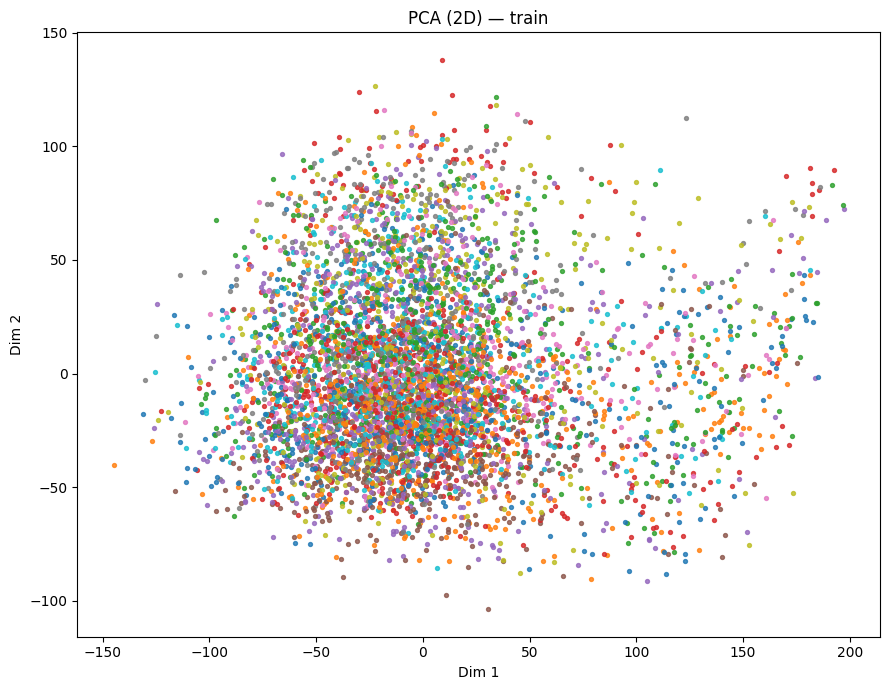

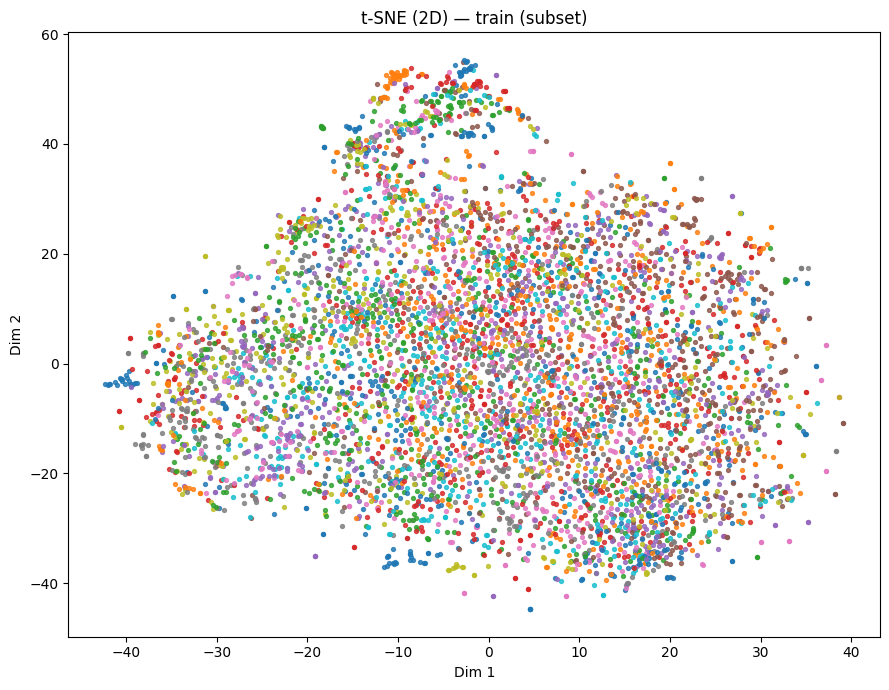

[PCA] kept dims: 691 | explained variance ≈ 0.950


In [ ]:
N = len(pixel_ds)
v0, y0, _, _ = pixel_ds[0]
D = int(np.asarray(v0).size)

X = np.empty((N, D), dtype=np.float32)
y = np.empty((N,), dtype=np.int64)

X[0] = np.asarray(v0, dtype=np.float32).reshape(-1)
y[0] = int(y0)

for i in range(1, N):
    vec, yi, _, _ = pixel_ds[i]
    X[i] = np.asarray(vec, dtype=np.float32).reshape(-1)
    y[i] = int(yi)

print(f"[Data] X: {X.shape}, y: {y.shape}, classes: {len(pixel_ds.le.classes_)}")


# train/test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
(train_idx, test_idx), = sss.split(X, y)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
print(f"[Split] train={X_train.shape}, test={X_test.shape}")

# standardize before PCA
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

# 2D visualization: PCA-2 and t-SNE-2
def plot_2d(X2, y, title):
    plt.figure(figsize=(9,7))
    classes = np.unique(y)
    for cls in classes:
        idx = np.where(y == cls)[0]
        plt.scatter(X2[idx,0], X2[idx,1], s=8, alpha=0.8, label=str(cls))
    plt.title(title); plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
    if len(classes) <= MAX_LEGEND_CLASSES:
        plt.legend(markerscale=2, fontsize=8, ncol=2, frameon=False)
    plt.tight_layout()
    plt.show()

# PCA-2 plot
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
plot_2d(pca2.fit_transform(X_train_std), y_train,
        "PCA (2D) — train")

# t-SNE-2
subset = min(10000, len(X_train_std))
perm = np.random.RandomState(RANDOM_STATE).choice(len(X_train_std), size=subset, replace=False)
perplexity = max(5, min(30, int(subset**0.5)))
tsne2 = TSNE(n_components=2, random_state=RANDOM_STATE, init="pca",
             learning_rate="auto", perplexity=perplexity)
plot_2d(tsne2.fit_transform(X_train_std[perm]), y_train[perm],
        "t-SNE (2D) — train (subset)")

# PCA for model features
PCA_VARIANCE_TARGET = 0.95
pca_full = PCA(n_components=PCA_VARIANCE_TARGET, svd_solver="full", random_state=RANDOM_STATE)
X_train_pca = pca_full.fit_transform(X_train_std)
X_test_pca  = pca_full.transform(X_test_std)
print(f"[PCA] kept dims: {X_train_pca.shape[1]} | explained variance ≈ {pca_full.explained_variance_ratio_.sum():.3f}")

# rescale after PCA
svm_scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = svm_scaler.fit_transform(X_train_pca)
X_test_scaled  = svm_scaler.transform(X_test_pca)

# **Prediction Models**

## **Simpler Models**

### Baseline: SVM on PCA

We standardize pixels → run PCA on **train only** → train an **Linear SVM** on the PCA features.

**Why this baseline?**  
SVM on PCA is strong for high-dimensional images with limited data.

**Reporting:**  
- Cross-validation on the **train** split  
- **Test accuracy** and **test macro-F1**  
(Use macro-F1 to treat all 75 classes fairly.)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[SVM] Test accuracy: 0.2262

Classification Report:

                           precision  recall  f1-score  support
ADONIS                         0.667   0.222     0.333    9.000
AFRICAN GIANT SWALLOWTAIL      0.750   0.429     0.545    7.000
AMERICAN SNOOT                 0.125   0.143     0.133    7.000
AN 88                          1.000   0.250     0.400    8.000
APPOLLO                        0.400   0.222     0.286    9.000
...                              ...     ...       ...      ...
YELLOW SWALLOW TAIL            0.500   0.143     0.222    7.000
ZEBRA LONG WING                0.000   0.000     0.000    8.000
accuracy                       0.226   0.226     0.226    0.226
macro avg                      0.339   0.222     0.232  650.000
weighted avg                   0.336   0.226     0.235  650.000

[78 rows x 4 columns]


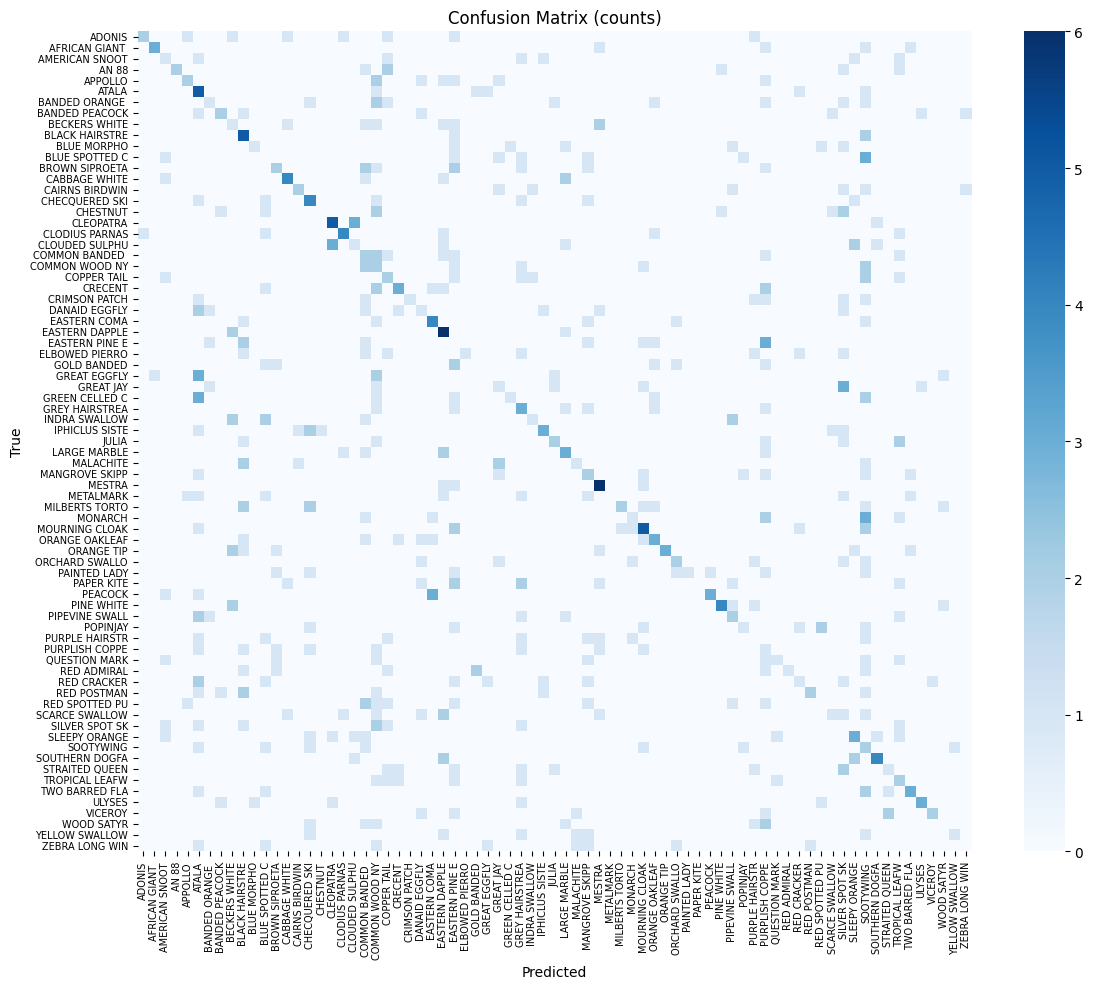

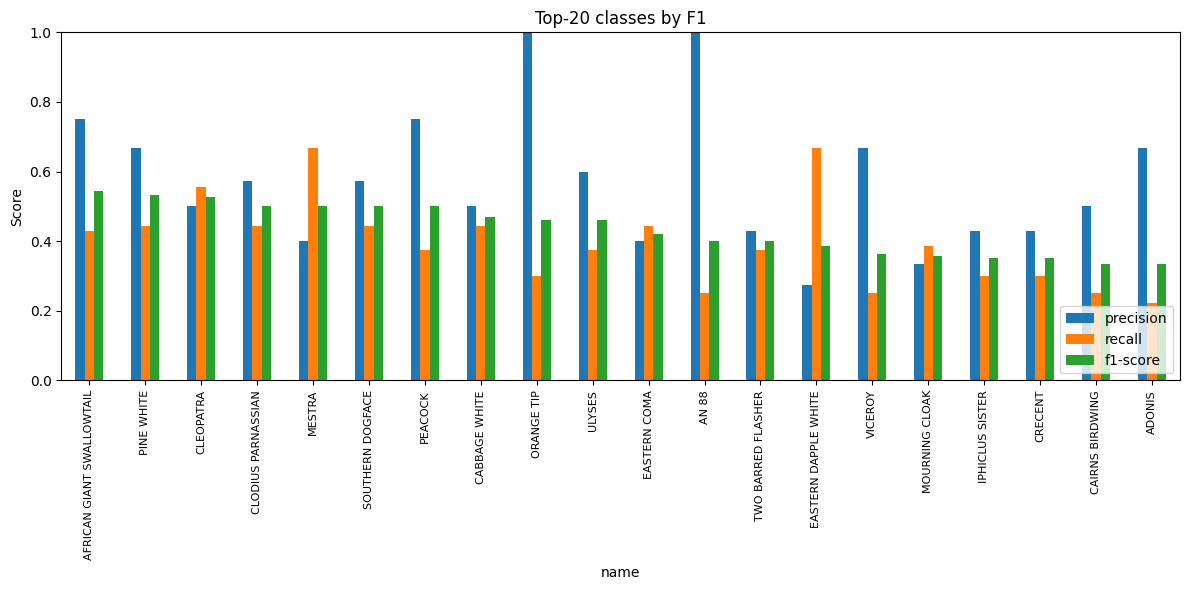

In [ ]:
# Train classifier
clf = SGDClassifier(loss="hinge", alpha=1e-4, random_state=RANDOM_STATE,
                    max_iter=500, tol=1e-3)
clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"[SVM] Test accuracy: {acc:.4f}")

report = classification_report(
    y_test, y_pred, target_names=class_names, output_dict=True, zero_division=0
)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:\n")
print(report_df.round(3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

def abbr(s, maxlen=14):
    s = s.replace("-", " ")
    out = " ".join(w[:10] for w in s.split())
    return out[:maxlen]
short_names = [abbr(s) for s in class_names]

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=short_names, yticklabels=short_names)
plt.title("Confusion Matrix (counts)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(rotation=90, fontsize=7); plt.yticks(fontsize=7)
plt.tight_layout(); plt.show()

cols = ["precision", "recall", "f1-score"]
per_class = report_df.iloc[:-1][cols].copy()
per_class = report_df.iloc[:-1][["precision", "recall", "f1-score"]].copy()
per_class["name"] = per_class.index
top = per_class.sort_values("f1-score", ascending=False).head(20).set_index("name")
ax = top.plot(kind="bar", figsize=(12, 6))
plt.title("Top-20 classes by F1")
plt.ylabel("Score"); plt.ylim(0, 1)
plt.xticks(rotation=90, fontsize=8)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### Baseline: Simple MLP on PCA

A small **MLP** on PCA features (e.g., 1–2 hidden layers + dropout) to learn lightweight non-linearities without images directly.

**Procedure:**  
- Fit PCA on **train** only, transform train/test  
- Train the MLP on train PCA features  
- Report **test accuracy** and **macro-F1**

**Note:** keep the same random seed when comparing to SVM.


Epoch 1/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/92 [00:00<?, ?it/s]

Early stopping triggered
[NN] Test accuracy: 0.3123

Classification Report (Neural Network):

                           precision  recall  f1-score  support
ADONIS                         0.700   0.778     0.737    9.000
AFRICAN GIANT SWALLOWTAIL      0.667   0.571     0.615    7.000
AMERICAN SNOOT                 0.125   0.143     0.133    7.000
AN 88                          1.000   0.625     0.769    8.000
APPOLLO                        0.500   0.444     0.471    9.000
...                              ...     ...       ...      ...
YELLOW SWALLOW TAIL            0.400   0.286     0.333    7.000
ZEBRA LONG WING                0.000   0.000     0.000    8.000
accuracy                       0.312   0.312     0.312    0.312
macro avg                      0.335   0.312     0.311  650.000
weighted avg                   0.335   0.312     0.311  650.000

[78 rows x 4 columns]


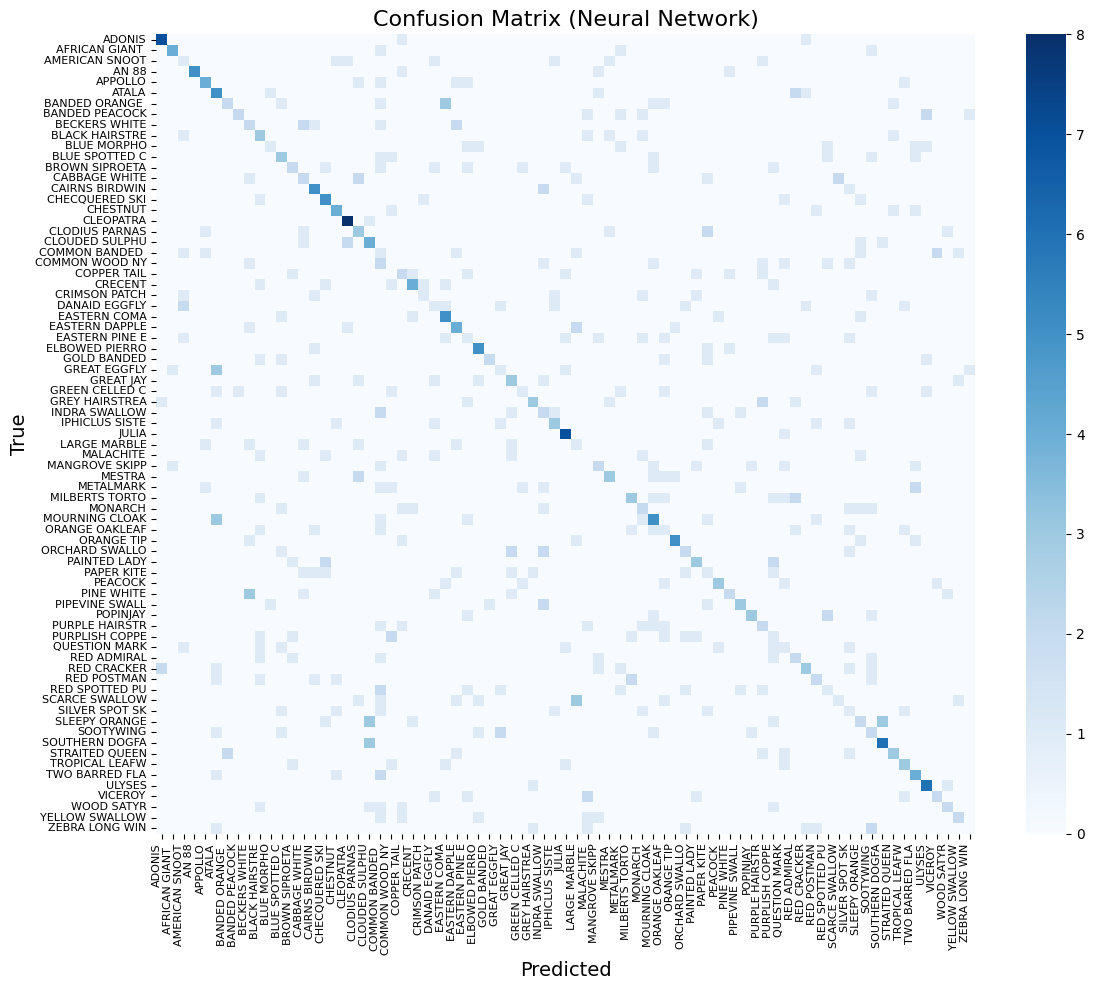

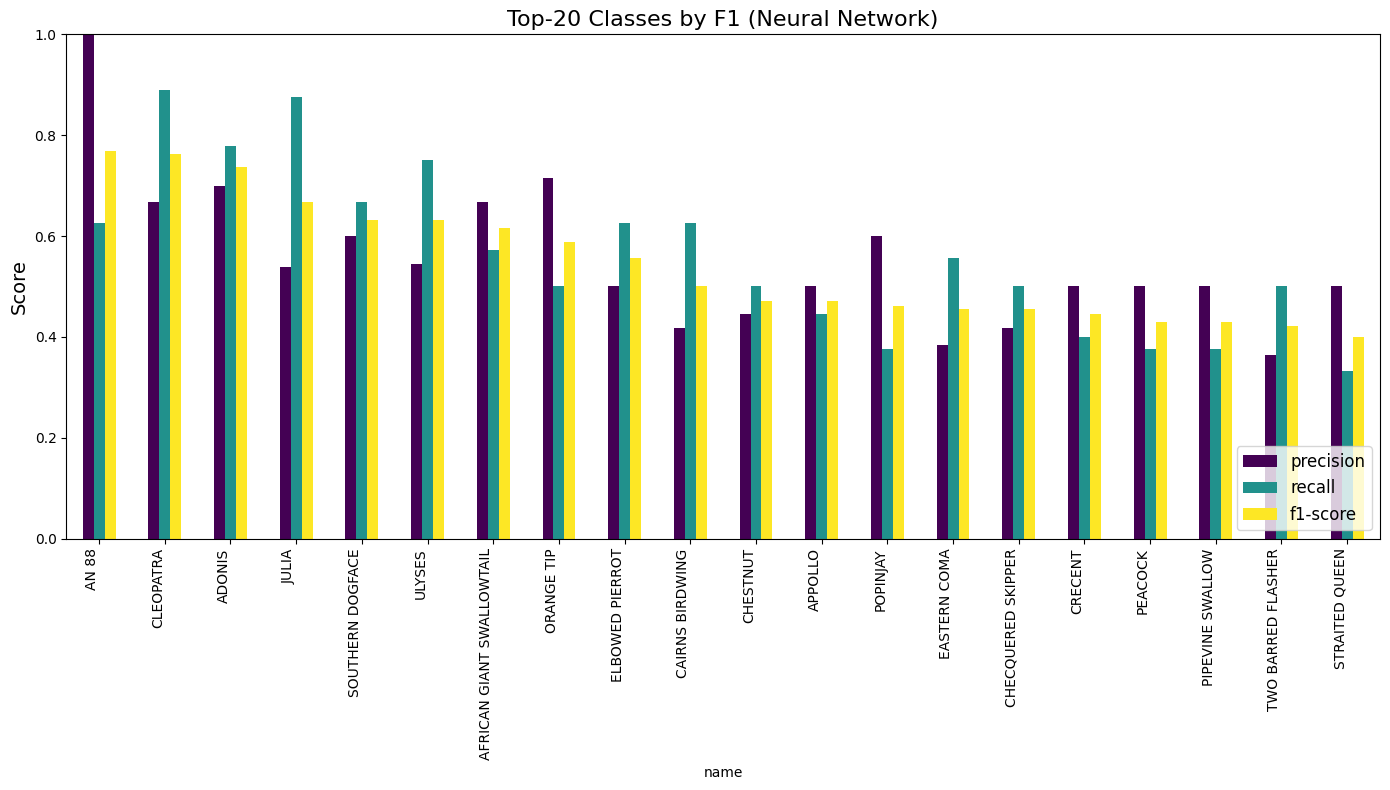

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

# Create training dataset and DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# create model
model = SimpleMLP(input_dim=X_train_scaled.shape[1], num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# train the model
best_acc = 0
patience, patience_counter = 50, 0

for epoch in range(100):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/100", leave=False)
    for xb, yb in loop:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Update tqdm postfix
        loop.set_postfix(loss=loss.item())

    # Validation accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            predicted = preds.argmax(dim=1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    acc = correct / total

    # Early stopping
    if acc > best_acc:
        best_acc = acc
        patience_counter = 0
        best_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Load best model
model.load_state_dict(best_state)

# evaluation
model.eval()
y_pred_nn = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        y_pred_nn.extend(preds.argmax(dim=1).cpu().numpy())

# accuracy
acc_nn = accuracy_score(y_test, y_pred_nn)
print(f"[NN] Test accuracy: {acc_nn:.4f}")

report_nn = classification_report(
    y_test, y_pred_nn, target_names=class_names, output_dict=True
)
report_df_nn = pd.DataFrame(report_nn).transpose()
print("\nClassification Report (Neural Network):\n")
print(report_df_nn.round(3))

cm_nn = confusion_matrix(y_test, y_pred_nn)

short_names_nn = [abbr(s) for s in class_names]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_nn, annot=False, cmap="Blues",
            xticklabels=short_names_nn,
            yticklabels=short_names_nn)
plt.title("Confusion Matrix (Neural Network)", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(rotation=90, ha="right", fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()


# --- Per-class metrics (NN) ---
cols = ["precision", "recall", "f1-score"]
per_class_nn = report_df_nn.iloc[:-1][cols].copy()
per_class_nn["name"] = per_class_nn.index

# Take Top-20 by F1
top_nn = per_class_nn.sort_values("f1-score", ascending=False).head(20).set_index("name")

ax = top_nn.plot(kind="bar", figsize=(14, 8), colormap="viridis")
plt.title("Top-20 Classes by F1 (Neural Network)", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=90, ha="right", fontsize=10)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()


## **Advanced Models**

from this point on we'll train on the images so we won't be able to use the PCA-produced data, we'll define:

In [ ]:
X_train_img = X_train.reshape(-1, H, W, 3).astype(np.float32)
X_test_img  = X_test.reshape(-1, H, W, 3).astype(np.float32)

### Convolutional Neural Network

Epoch 1/20 | Train Loss: 4.0689 | Val Acc: 0.1455
Epoch 2/20 | Train Loss: 3.2049 | Val Acc: 0.3425
Epoch 3/20 | Train Loss: 2.5983 | Val Acc: 0.4332
Epoch 4/20 | Train Loss: 2.1434 | Val Acc: 0.5205
Epoch 5/20 | Train Loss: 1.8571 | Val Acc: 0.5240
Epoch 6/20 | Train Loss: 1.6009 | Val Acc: 0.5753
Epoch 7/20 | Train Loss: 1.4411 | Val Acc: 0.5788
Epoch 8/20 | Train Loss: 1.2561 | Val Acc: 0.5873
Epoch 9/20 | Train Loss: 1.1054 | Val Acc: 0.5856
Epoch 10/20 | Train Loss: 0.9900 | Val Acc: 0.6113
Epoch 11/20 | Train Loss: 0.8600 | Val Acc: 0.6182
Epoch 12/20 | Train Loss: 0.7565 | Val Acc: 0.6284
Epoch 13/20 | Train Loss: 0.6984 | Val Acc: 0.6062
Epoch 14/20 | Train Loss: 0.6181 | Val Acc: 0.6233
Epoch 15/20 | Train Loss: 0.5536 | Val Acc: 0.6336
Epoch 16/20 | Train Loss: 0.4980 | Val Acc: 0.6301
Epoch 17/20 | Train Loss: 0.4717 | Val Acc: 0.6113
Epoch 18/20 | Train Loss: 0.4300 | Val Acc: 0.6216
Epoch 19/20 | Train Loss: 0.3986 | Val Acc: 0.6336
Epoch 20/20 | Train Loss: 0.3577 | Val A

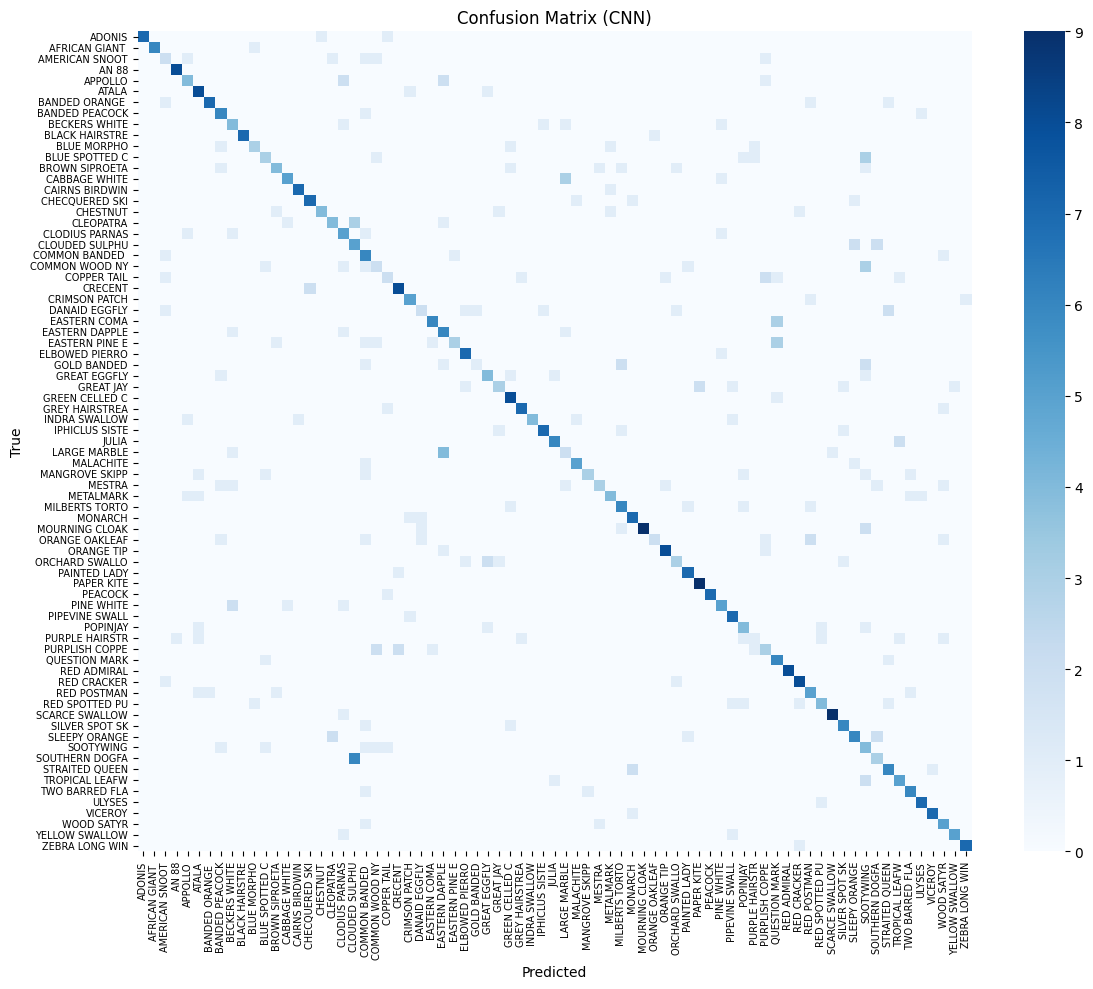

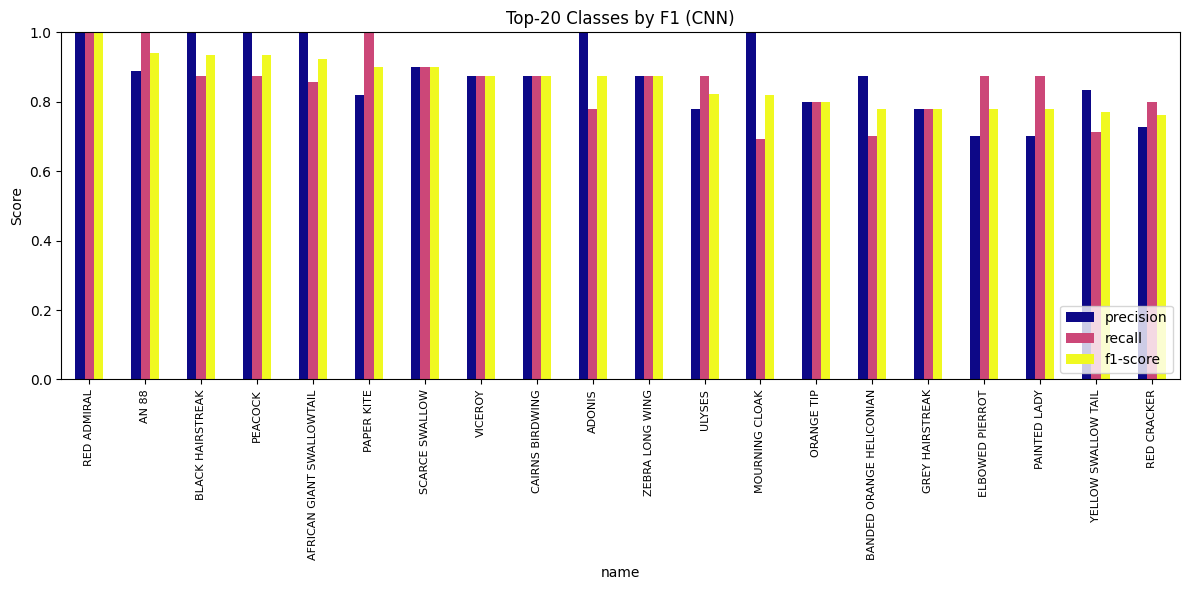

In [ ]:
assert X_train_img.ndim == 4 and X_train_img.shape[-1] == 3, "X_train_img must be (N,H,W,3)"
assert X_test_img.ndim  == 4 and X_test_img.shape[-1]  == 3, "X_test_img must be (N,H,W,3)"
H, W = X_train_img.shape[1], X_train_img.shape[2]

if X_train_img.dtype != np.float32: X_train_img = X_train_img.astype(np.float32, copy=False)
if X_test_img.dtype  != np.float32: X_test_img  = X_test_img.astype(np.float32, copy=False)

if np.nanmax(X_train_img) > 1.0 or np.nanmax(X_test_img) > 1.0:
    X_train_img = X_train_img / 255.0
    X_test_img  = X_test_img  / 255.0

X_train_t = torch.from_numpy(np.transpose(X_train_img, (0, 3, 1, 2))).float()
X_test_t  = torch.from_numpy(np.transpose(X_test_img,  (0, 3, 1, 2))).float()
y_train_t = torch.from_numpy(y_train).long()
y_test_t  = torch.from_numpy(y_test).long()

X_train_t = (X_train_t - 0.5) / 0.5
X_test_t  = (X_test_t  - 0.5) / 0.5

val_frac = (VAL_SIZE if "VAL_SIZE" in globals() else 0.1)  # default 10% val
val_size = max(1, int(val_frac * len(X_train_t)))
train_size = len(X_train_t) - val_size

g = torch.Generator().manual_seed(RANDOM_STATE) if "RANDOM_STATE" in globals() else None
full_train_ds = TensorDataset(X_train_t, y_train_t)
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size], generator=g)

use_cuda = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=use_cuda)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=2, pin_memory=use_cuda)

test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=128, shuffle=False,
                          num_workers=2, pin_memory=use_cuda)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),   # H,W -> /2
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),   # -> /4
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),   # -> /8
            nn.AdaptiveAvgPool2d((8, 8))  # ensure 8x8 regardless of input size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

num_classes = len(class_names) if "class_names" in globals() else int(y_train_t.max().item() + 1)

device = "cuda" if use_cuda else "cpu"
model = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 20
for epoch in range(EPOCHS):
    # train model
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)

    # validate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / max(1, total)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {running_loss/len(train_ds):.4f} | Val Acc: {val_acc:.4f}")

# evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())

y_pred_cnn = np.concatenate(all_preds)
y_true_cnn = np.concatenate(all_labels)

# accuracy
acc_cnn = accuracy_score(y_true_cnn, y_pred_cnn)
print(f"[CNN] Test accuracy: {acc_cnn:.4f}")

report_cnn = classification_report(
    y_true_cnn, y_pred_cnn, target_names=class_names, output_dict=True
)
report_df_cnn = pd.DataFrame(report_cnn).transpose()
print("\nClassification Report (CNN):\n")
print(report_df_cnn.round(3))

# confusion matrix
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)

short_names_cnn = [abbr(s) for s in class_names]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_cnn, annot=False, cmap="Blues",
            xticklabels=short_names_cnn, yticklabels=short_names_cnn)
plt.title("Confusion Matrix (CNN)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(rotation=90, fontsize=7); plt.yticks(fontsize=7)
plt.tight_layout(); plt.show()

# ---- Metrics per Class (CNN) ----
cols = ["precision", "recall", "f1-score"]
per_class_cnn = report_df_cnn.iloc[:-1][cols].copy()
per_class_cnn["name"] = per_class_cnn.index

top_cnn = per_class_cnn.sort_values("f1-score", ascending=False).head(20).set_index("name")
ax = top_cnn.plot(kind="bar", figsize=(12, 6), colormap="plasma")
plt.title("Top-20 Classes by F1 (CNN)")
plt.ylabel("Score"); plt.ylim(0, 1)
plt.xticks(rotation=90, fontsize=8)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### Understanding the process of the CNN

Neural networks can be hard to interpret because we don’t always know *why* they predict a certain class.  
Grad-CAM (Gradient-weighted Class Activation Mapping) gives us a way to “look inside” the CNN.  
It highlights the regions of an input image that most strongly influenced the model’s decision.  
By overlaying these heatmaps on butterfly images, we can see which visual features the network focuses on.


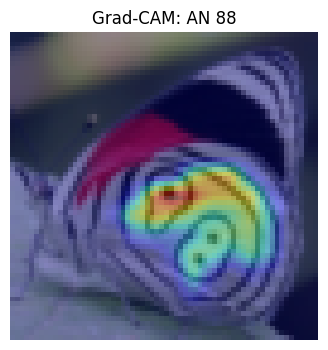

In [ ]:
# Get the last conv layer
def get_last_conv_layer(net: nn.Module):
    for m in reversed(list(net.features)):
        if isinstance(m, nn.Conv2d):
            return m
    raise RuntimeError("No Conv2d layer found in model.features")

LAST_CONV = get_last_conv_layer(model)

# Preprocess helper
def preprocess_np_img(img_np: np.ndarray, device: str):
    t = torch.from_numpy(img_np.transpose(2,0,1)).float()
    t = (t - 0.5) / 0.5
    return t.unsqueeze(0).to(device)

# Grad-CAM for one image
def gradcam_single(model, x_in: torch.Tensor, target_layer: nn.Module, target_class=None):
    model.eval()
    feats, grads = [], []

    def f_hook(_m, _i, o): feats.append(o)
    def b_hook(_m, gi, go): grads.append(go[0])

    h_f = target_layer.register_forward_hook(f_hook)
    try:
        h_b = target_layer.register_full_backward_hook(b_hook)
    except AttributeError:
        h_b = target_layer.register_backward_hook(b_hook)

    logits = model(x_in)
    if target_class is None:
        target_class = int(logits.argmax(dim=1).item())
    loss = logits[0, target_class]

    model.zero_grad(set_to_none=True)
    loss.backward()

    A, dA = feats[0], grads[0]
    weights = dA.mean(dim=(2,3), keepdim=True)
    cam = (weights * A).sum(dim=1).squeeze()
    cam = torch.relu(cam)
    cam = cam / (cam.max() + 1e-8)
    cam_np = cam.detach().cpu().numpy()

    h_f.remove(); h_b.remove()
    return cam_np, target_class

# Show heatmap overlay inline
def show_gradcam_overlay(cam_np, img_np, title=""):
    H, W = img_np.shape[:2]
    cam_t = torch.from_numpy(cam_np)[None, None].float()
    cam_up = F.interpolate(cam_t, size=(H,W), mode="bilinear", align_corners=False).squeeze().numpy()

    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.imshow(cam_up, cmap="jet", alpha=0.4)
    plt.axis("off")
    if title: plt.title(title)
    plt.show()

# Run on a test image
idx = 0
img_np = X_test_img[idx]
x_in = preprocess_np_img(img_np, device)

cam_np, c_idx = gradcam_single(model, x_in, LAST_CONV)
cls_name = class_names[c_idx] if "class_names" in globals() else str(c_idx)

show_gradcam_overlay(cam_np, img_np, title=f"Grad-CAM: {cls_name}")


### **Using CLIP**

#### CLIP (Frozen) — Embeddings + Simple Head

We extract **frozen CLIP embeddings** for all images, then reuse the same simple heads as above (**SVM and/or MLP**) on top of those embeddings.

**Steps:**  
1) Embed train/test with CLIP (no tuning).  
2) Train a head on train embeddings.  
3) Evaluate on test (accuracy + macro-F1).

**Expectation:** should beat PCA baselines due to stronger features.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


extract embeddings:   0%|          | 0/23 [00:00<?, ?batch/s]

extract embeddings:   0%|          | 0/3 [00:00<?, ?batch/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== classic models on frozen clip embeddings ===
       model  cv_acc_mean  cv_acc_std  test_acc  test_macro_f1  train_secs
0  LinearSVM     0.861341    0.009128  0.858462       0.852564   56.280760
1     LogReg     0.709348    0.012265  0.764615       0.750872   66.749251
2        KNN     0.720292    0.011314  0.741538       0.739281    2.270793


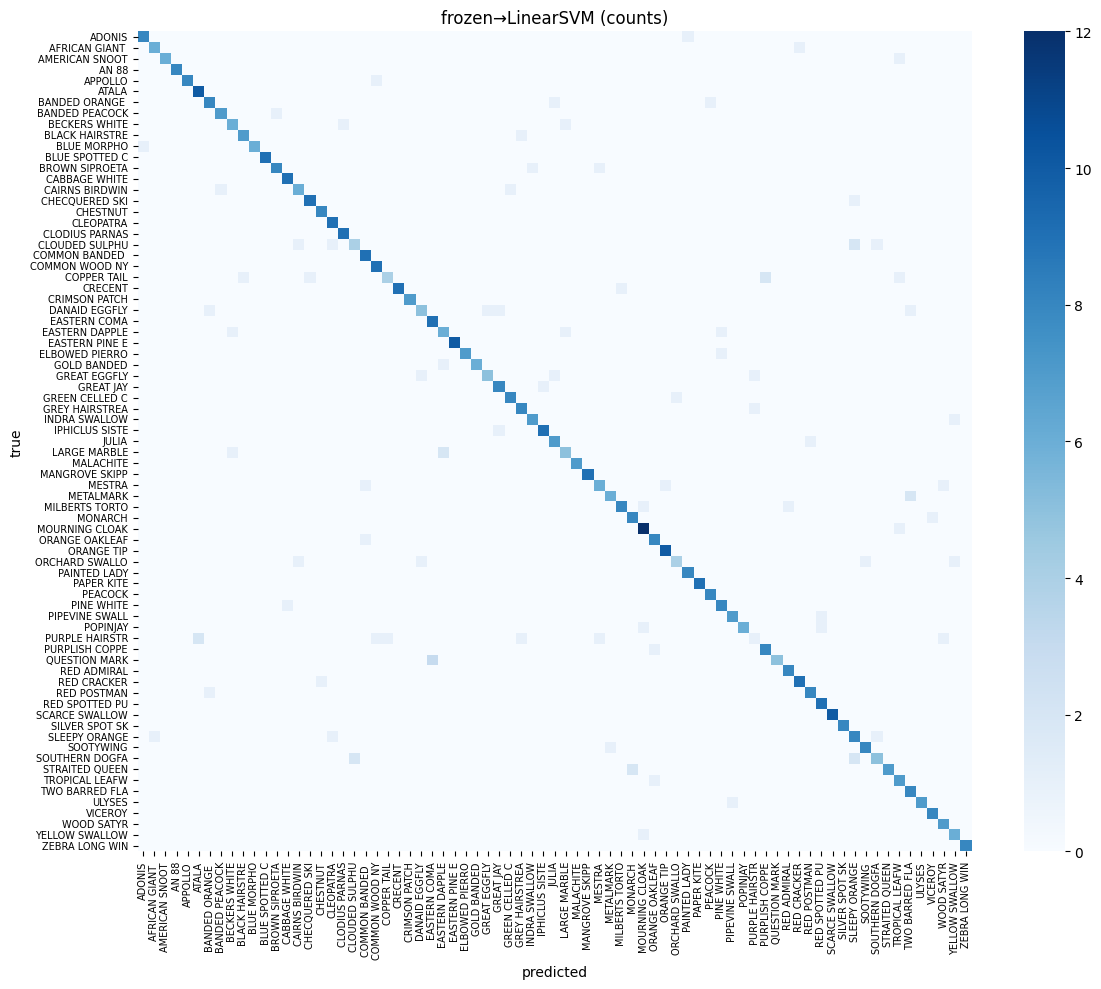

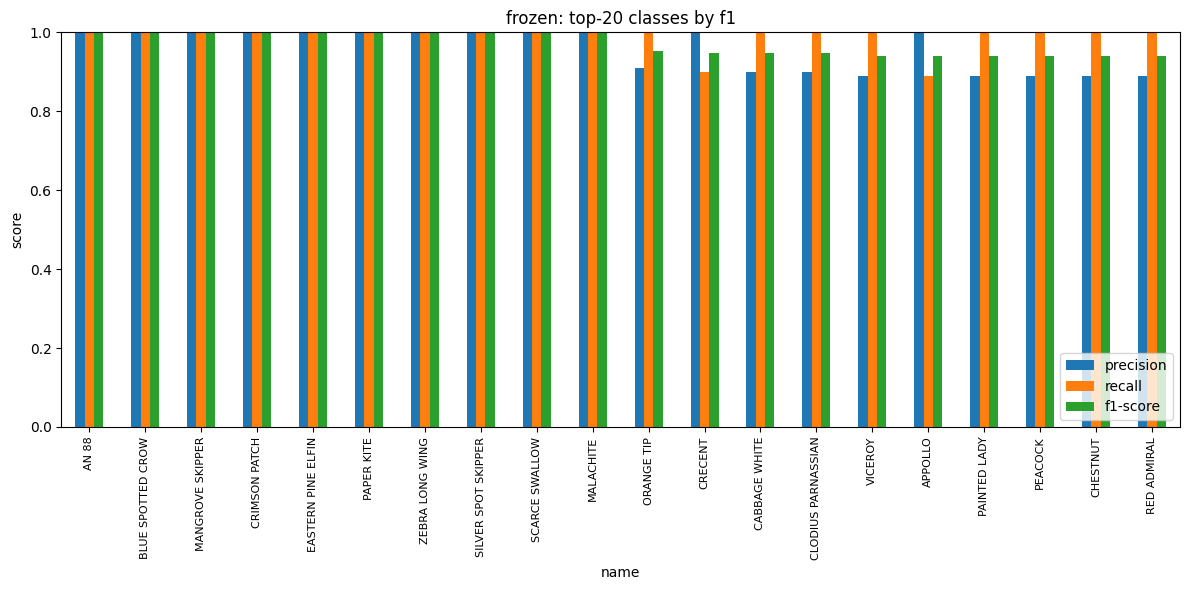

In [ ]:
# device + amp
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP = bool(MIXED_PRECISION and (device.type == "cuda"))

# small helpers
def savefig(name):
  return # we need to present the figures not save them

def abbr(s, maxlen=14):
    s = s.replace("-", " ")
    out = " ".join(w[:10] for w in s.split())
    return out[:maxlen]

# csv → (paths, labels) with light auto-detect
df = pd.read_csv(CSV_PATH)
cand_img = ["filename"]
cand_lbl = ["label"]
image_col = cand_img[0]
label_col = cand_lbl[0]

def _full_path(p):
    p = str(p)
    if os.path.isabs(p): return p
    return os.path.join(IMG_DIR, p)

paths = [p for p in map(_full_path, df[image_col].tolist())
         if os.path.splitext(p)[1].lower() in VALID_EXT and os.path.exists(p)]
labels = df.loc[[os.path.basename(_full_path(x)) in [os.path.basename(p) for p in paths] for x in df[image_col]], label_col].astype(str).tolist()
assert len(paths) == len(labels), "paths/labels length mismatch after filtering"

# label encoder (train only)
le = LabelEncoder()
# we’ll split first, then fit on y_train only

# clip model + transforms
base_model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
    OPENCLIP_MODEL, pretrained=OPENCLIP_PRETRAINED
)
base_model.to(device).eval()

# dataset over file paths
class PathImageDataset(Dataset):
    def __init__(self, paths, labels, preprocess, label_encoder: LabelEncoder = None):
        self.paths = paths
        self.labels_str = np.array(labels, dtype=object)
        self.preprocess = preprocess
        self.le = label_encoder
        self.labels_idx = None if self.le is None else self.le.transform(self.labels_str)
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        x = self.preprocess(img)
        y_str = str(self.labels_str[i])
        y_idx = -1 if self.le is None else int(self.labels_idx[i])
        y_idx = torch.tensor(y_idx if y_idx >= 0 else 0, dtype=torch.long)
        meta = self.paths[i]
        return x, y_idx, y_str, meta

# train/val/test split (stratified)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
idx = np.arange(len(labels))
train_idx, test_idx = next(sss1.split(idx, labels))
paths_train, paths_test = [paths[i] for i in train_idx], [paths[i] for i in test_idx]
labels_train, labels_test = [labels[i] for i in train_idx], [labels[i] for i in test_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE/(1.0-TEST_SIZE), random_state=RANDOM_STATE)
idx_tr = np.arange(len(labels_train))
train_idx2, val_idx = next(sss2.split(idx_tr, labels_train))
paths_tr, paths_val = [paths_train[i] for i in train_idx2], [paths_train[i] for i in val_idx]
labels_tr, labels_val = [labels_train[i] for i in train_idx2], [labels_train[i] for i in val_idx]

# fit encoder on train only
le.fit(labels_tr)
class_names = list(le.classes_)

# datasets/dataloaders (aug for train, clean for val/test)
ds_train = PathImageDataset(paths_tr,  labels_tr,  preprocess_train, le)
ds_val   = PathImageDataset(paths_val, labels_val, preprocess_val,   le)
ds_test  = PathImageDataset(paths_test, labels_test, preprocess_val, le)

# for classic models we also want train+val embeddings
paths_trval  = paths_tr + paths_val
labels_trval = labels_tr + labels_val
ds_trval = PathImageDataset(paths_trval, labels_trval, preprocess_val, le)

pin = (device.type == "cuda")
num_workers = max(2, (os.cpu_count() or 8) // 2)

dl_train    = DataLoader(ds_train,  batch_size=BATCH_SIZE_TRAIN, shuffle=True,
                         num_workers=num_workers, pin_memory=pin, persistent_workers=True, prefetch_factor=2)
dl_val      = DataLoader(ds_val,    batch_size=BATCH_SIZE_EVAL,  shuffle=False,
                         num_workers=num_workers, pin_memory=pin, persistent_workers=True, prefetch_factor=2)
dl_trval    = DataLoader(ds_trval,  batch_size=BATCH_SIZE_EVAL,  shuffle=False,
                         num_workers=num_workers, pin_memory=pin, persistent_workers=True, prefetch_factor=2)
dl_test     = DataLoader(ds_test,   batch_size=BATCH_SIZE_EVAL,  shuffle=False,
                         num_workers=num_workers, pin_memory=pin, persistent_workers=True, prefetch_factor=2)

# embeddings (with amp only on cuda if enabled)
@torch.no_grad()
def extract_embeddings(loader, base_model, device, amp=AMP):
    base_model.eval()
    all_emb, all_lbl = [], []
    for images, _, y_str, _ in tqdm(loader, desc="extract embeddings", unit="batch"):
        images = images.to(device, non_blocking=pin)
        ctx = torch.autocast(device_type="cuda", enabled=amp)
        with ctx:
            feats = base_model.encode_image(images)
            feats = feats / feats.norm(dim=1, keepdim=True).clamp(min=1e-12)
        all_emb.append(feats.float().cpu().numpy())
        all_lbl.extend(y_str)
    return np.concatenate(all_emb, axis=0), all_lbl

emb_trval, lab_trval = extract_embeddings(dl_trval, base_model, device)
emb_test,  lab_test  = extract_embeddings(dl_test,   base_model, device)
y_trval = le.transform(lab_trval)
y_test_enc = le.transform(lab_test)

# classic models on frozen clip
def make_models() -> Dict[str, object]:
    return {
        "LinearSVM": LinearSVC(C=1.0, random_state=RANDOM_STATE),
        "KNN": KNeighborsClassifier(n_neighbors=5, metric="cosine", weights="distance", n_jobs=-1),
        "LogReg": LogisticRegression(multi_class="multinomial", solver="saga",
                                     max_iter=1000, n_jobs=-1, random_state=RANDOM_STATE),
    }

def evaluate_models(X_train, y_train, X_test, y_test):
    cv = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
    models = make_models(); rows, preds = [], {}
    for name, model in models.items():
        t0 = time.perf_counter()
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test); preds[name] = y_pred
        rows.append({
            "model": name,
            "cv_acc_mean": float(np.mean(cv_scores)),
            "cv_acc_std": float(np.std(cv_scores)),
            "test_acc": accuracy_score(y_test, y_pred),
            "test_macro_f1": f1_score(y_test, y_pred, average="macro"),
            "train_secs": time.perf_counter() - t0
        })
    df = pd.DataFrame(rows).sort_values("test_acc", ascending=False).reset_index(drop=True)
    return df, models, preds

results_frozen, frozen_models, frozen_preds = evaluate_models(emb_trval, y_trval, emb_test, y_test_enc)
print("\n=== classic models on frozen clip embeddings ===")
print(results_frozen)

# visuals
def report_df(y_true, y_pred, class_names):
    rep = classification_report(
        y_true, y_pred, labels=list(range(len(class_names))),
        target_names=class_names, output_dict=True, zero_division=0
    )
    return pd.DataFrame(rep).T

def plot_cm(cm, classes, title):
    short = [abbr(s) for s in classes]
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=short, yticklabels=short)
    plt.title(title); plt.xlabel("predicted"); plt.ylabel("true")
    plt.xticks(rotation=90, fontsize=7); plt.yticks(fontsize=7)
    plt.tight_layout(); savefig(f"{title}.png"); plt.show()

def plot_top20_f1(df, title):
    cols = ["precision", "recall", "f1-score"]
    per_class = df.iloc[:-1][cols].copy(); per_class["name"] = per_class.index
    top = per_class.sort_values("f1-score", ascending=False).head(20).set_index("name")
    ax = top.plot(kind="bar", figsize=(12,6))
    plt.title(title); plt.ylabel("score"); plt.ylim(0,1)
    plt.xticks(rotation=90, fontsize=8)
    plt.legend(loc="lower right"); plt.tight_layout(); savefig(f"{title}.png"); plt.show()

best_frozen_name = results_frozen.iloc[0]["model"]
y_pred_frozen = frozen_preds[best_frozen_name]
cm_frozen = confusion_matrix(y_test_enc, y_pred_frozen, labels=list(range(len(class_names))))
rep_frozen = report_df(y_test_enc, y_pred_frozen, class_names)

plot_cm(cm_frozen, class_names, title=f"frozen→{best_frozen_name} (counts)")
plot_top20_f1(rep_frozen, title="frozen: top-20 classes by f1")


#### CLIP (Fine-Tuned) — Re-embed and Re-train

We **fine-tune CLIP** on the train set, then **re-embed** images and **re-train the same head(s)** for a fair comparison.

**Steps:**  
1) Fine-tune CLIP on train.  
2) Recompute embeddings (train/test).  
3) Re-train SVM/MLP head on train embeddings.  
4) Evaluate on test; compare vs. frozen.

**Goal:** improved **macro-F1**, especially for visually similar species.


In [ ]:
class CLIPWithHead(nn.Module):
    def __init__(self, base_model: nn.Module, num_classes: int):
        super().__init__()
        self.base = base_model
        emb_dim = getattr(self.base, "embed_dim", getattr(self.base.visual, "output_dim"))
        self.head = nn.Linear(emb_dim, num_classes)
    def forward(self, images):
        feats = self.base.encode_image(images)
        feats = feats / feats.norm(dim=1, keepdim=True).clamp(min=1e-12)
        return self.head(feats), feats

def set_trainable_params(model, mode="last_k", last_k=UNFREEZE_LAST_BLOCKS):
    for p in model.base.parameters(): p.requires_grad = False
    for p in model.head.parameters(): p.requires_grad = True
    if mode == "full":
        for p in model.base.parameters(): p.requires_grad = True
        return
    vis = model.base.visual
    if hasattr(vis, "transformer") and hasattr(vis.transformer, "resblocks"):
        for blk in vis.transformer.resblocks[-last_k:]:
            for p in blk.parameters(): p.requires_grad = True
        if hasattr(vis, "ln_post"):
            for p in vis.ln_post.parameters(): p.requires_grad = True
        if hasattr(vis, "proj") and isinstance(getattr(vis, "proj"), torch.nn.Parameter):
            vis.proj.requires_grad = True
    if hasattr(vis, "layer4"):
        for p in vis.layer4.parameters(): p.requires_grad = True

def make_optimizer(model, head_lr=None, base_lr=None, weight_decay=WEIGHT_DECAY):
    head_lr = head_lr or (LR * 5.0)
    base_lr = base_lr or LR
    head_params = [p for p in model.head.parameters() if p.requires_grad]
    base_params = [p for p in model.base.parameters() if p.requires_grad]
    groups = []
    if head_params: groups.append({"params": head_params, "lr": head_lr})
    if base_params: groups.append({"params": base_params, "lr": base_lr})
    return optim.AdamW(groups, weight_decay=weight_decay)

def run_finetune(model, device, train_loader, val_loader, epochs=EPOCHS,
                 label_smoothing=LABEL_SMOOTHING, early_stop=EARLY_STOP_PATIENCE, amp=AMP):
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = make_optimizer(model)
    total_steps = len(train_loader) * epochs
    sched = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=[pg["lr"] for pg in optimizer.param_groups],
        total_steps=total_steps, pct_start=0.1
    )
    scaler = torch.cuda.amp.GradScaler(enabled=amp)
    best_state, best_val, patience = None, -1.0, 0

    try:
        model = torch.compile(model)  # pytorch 2.x
    except Exception:
        pass

    for epoch in range(epochs):
        model.train(); correct = total = 0
        for x, y, *_ in dl_train:
            x, y = x.to(device, non_blocking=pin), y.to(device, non_blocking=pin)
            optimizer.zero_grad(set_to_none=True)
            ctx = torch.autocast(device_type="cuda", enabled=amp)
            with ctx:
                logits, _ = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            sched.step()
            correct += (logits.argmax(1) == y).sum().item(); total += y.size(0)
        train_acc = correct / max(1,total)

        model.eval(); correct = total = 0
        with torch.inference_mode():
            for x, y, *_ in dl_val:
                x, y = x.to(device, non_blocking=pin), y.to(device, non_blocking=pin)
                ctx = torch.autocast(device_type="cuda", enabled=amp)
                with ctx:
                    logits, _ = model(x)
                correct += (logits.argmax(1) == y).sum().item(); total += y.size(0)
        val_acc = correct / max(1,total)
        print(f"epoch {epoch+1}: train_acc={train_acc:.4f} val_acc={val_acc:.4f}")

        if val_acc > best_val:
            best_val, best_state, patience = val_acc, copy.deepcopy(model.state_dict()), 0
        else:
            patience += 1
            if patience >= early_stop:
                print("early stop"); break

    if best_state is not None: model.load_state_dict(best_state)
    return model

num_classes = len(class_names)
model_ft = CLIPWithHead(base_model, num_classes).to(device)
set_trainable_params(model_ft, mode="last_k", last_k=UNFREEZE_LAST_BLOCKS)

print("\n=== fine-tuning clip ===")
model_ft = run_finetune(model_ft, device, dl_train, dl_val)



=== fine-tuning clip ===


/tmp/ipython-input-1434709994.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp)
W0927 22:03:01.203000 343 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


epoch 1: train_acc=0.0944 val_acc=0.3908
epoch 2: train_acc=0.6059 val_acc=0.7354
epoch 3: train_acc=0.8153 val_acc=0.8338
epoch 4: train_acc=0.8913 val_acc=0.8708
epoch 5: train_acc=0.9190 val_acc=0.8877
epoch 6: train_acc=0.9358 val_acc=0.9046
epoch 7: train_acc=0.9575 val_acc=0.9015
epoch 8: train_acc=0.9646 val_acc=0.9169
epoch 9: train_acc=0.9717 val_acc=0.9231
epoch 10: train_acc=0.9771 val_acc=0.9185
epoch 11: train_acc=0.9812 val_acc=0.9292
epoch 12: train_acc=0.9879 val_acc=0.9400
epoch 13: train_acc=0.9927 val_acc=0.9431
epoch 14: train_acc=0.9927 val_acc=0.9385
epoch 15: train_acc=0.9963 val_acc=0.9308
epoch 16: train_acc=0.9967 val_acc=0.9385
epoch 17: train_acc=0.9969 val_acc=0.9354
early stop


extract embeddings:   0%|          | 0/23 [00:00<?, ?batch/s]

extract embeddings:   0%|          | 0/3 [00:00<?, ?batch/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== classic models on fine-tuned clip embeddings ===
       model  cv_acc_mean  cv_acc_std  test_acc  test_macro_f1  train_secs
0  LinearSVM     0.990938    0.002892  0.932308       0.931610   58.114438
1     LogReg     0.991109    0.002270  0.932308       0.931565   67.649715
2        KNN     0.990938    0.003182  0.930769       0.930121    1.128311


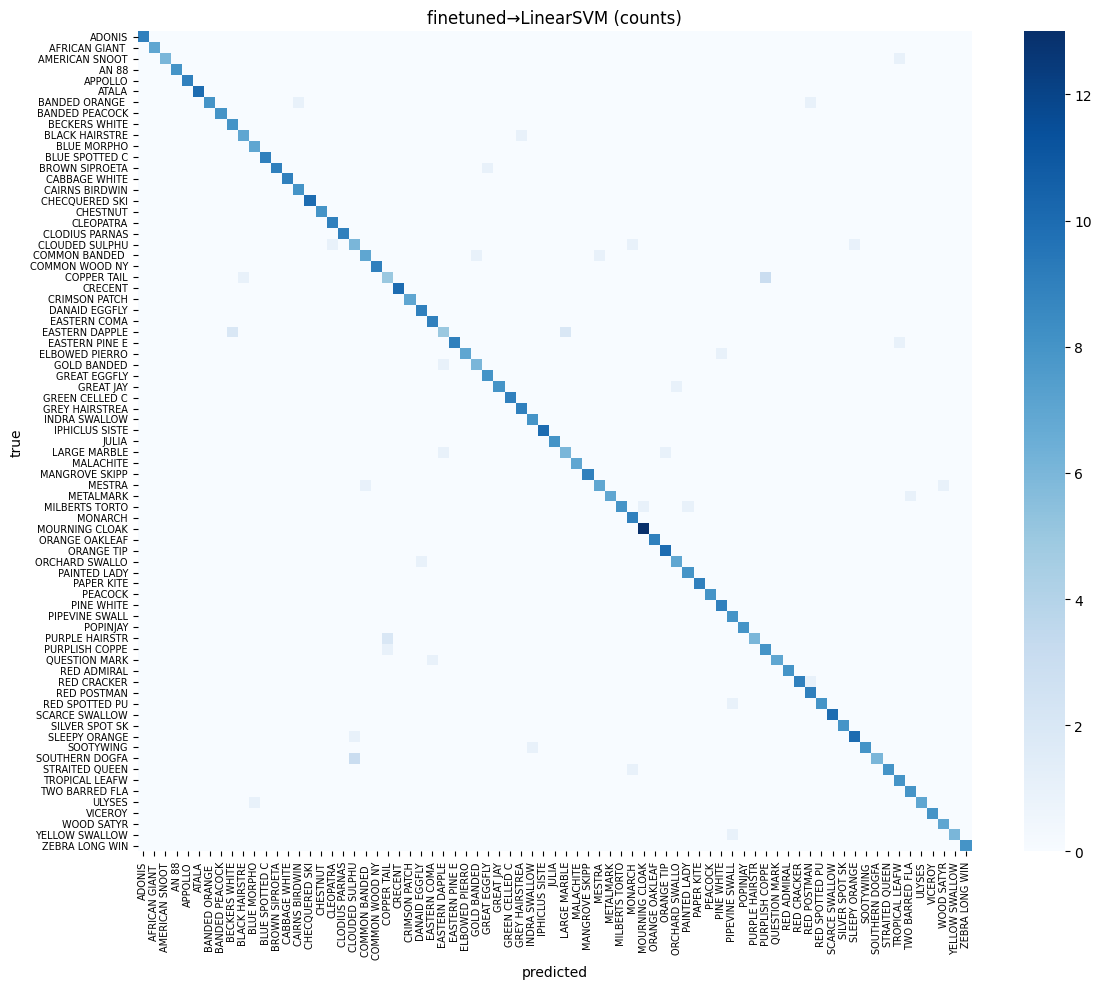

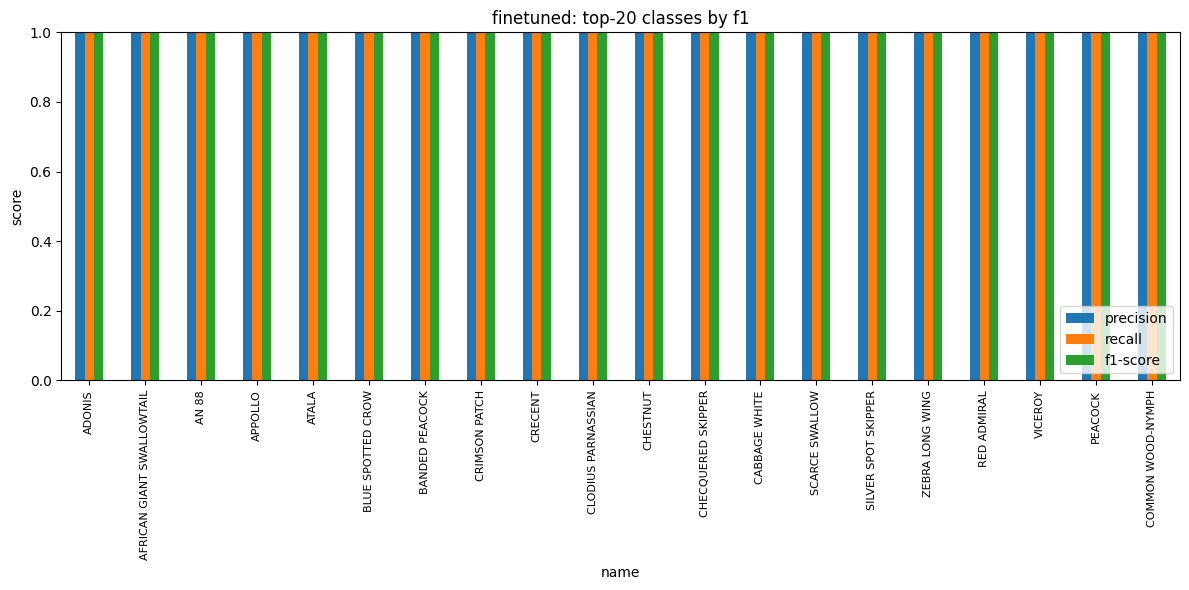

In [ ]:
emb_trval_ft, lab_trval_ft = extract_embeddings(dl_trval, model_ft.base, device)
emb_test_ft,  lab_test_ft  = extract_embeddings(dl_test,   model_ft.base, device)
y_trval_ft = le.transform(lab_trval_ft)
y_test_enc_ft = le.transform(lab_test_ft)

results_ft, ft_models, ft_preds = evaluate_models(emb_trval_ft, y_trval_ft, emb_test_ft, y_test_enc_ft)
print("\n=== classic models on fine-tuned clip embeddings ===")
print(results_ft)

best_ft_name = results_ft.iloc[0]["model"]
y_pred_ft = ft_preds[best_ft_name]
cm_ft = confusion_matrix(y_test_enc_ft, y_pred_ft, labels=list(range(len(class_names))))
rep_ft = report_df(y_test_enc_ft, y_pred_ft, class_names)

plot_cm(cm_ft, class_names, title=f"finetuned→{best_ft_name} (counts)")
plot_top20_f1(rep_ft, title="finetuned: top-20 classes by f1")


let's compare the results

       model  cv_acc_mean  cv_acc_std  test_acc  test_macro_f1  train_secs  \
0        KNN     0.990938    0.003182  0.930769       0.930121    1.128311   
1        KNN     0.720292    0.011314  0.741538       0.739281    2.270793   
2  LinearSVM     0.990938    0.002892  0.932308       0.931610   58.114438   
3  LinearSVM     0.861341    0.009128  0.858462       0.852564   56.280760   
4     LogReg     0.991109    0.002270  0.932308       0.931565   67.649715   
5     LogReg     0.709348    0.012265  0.764615       0.750872   66.749251   

       stage  
0  finetuned  
1     frozen  
2  finetuned  
3     frozen  
4  finetuned  
5     frozen  


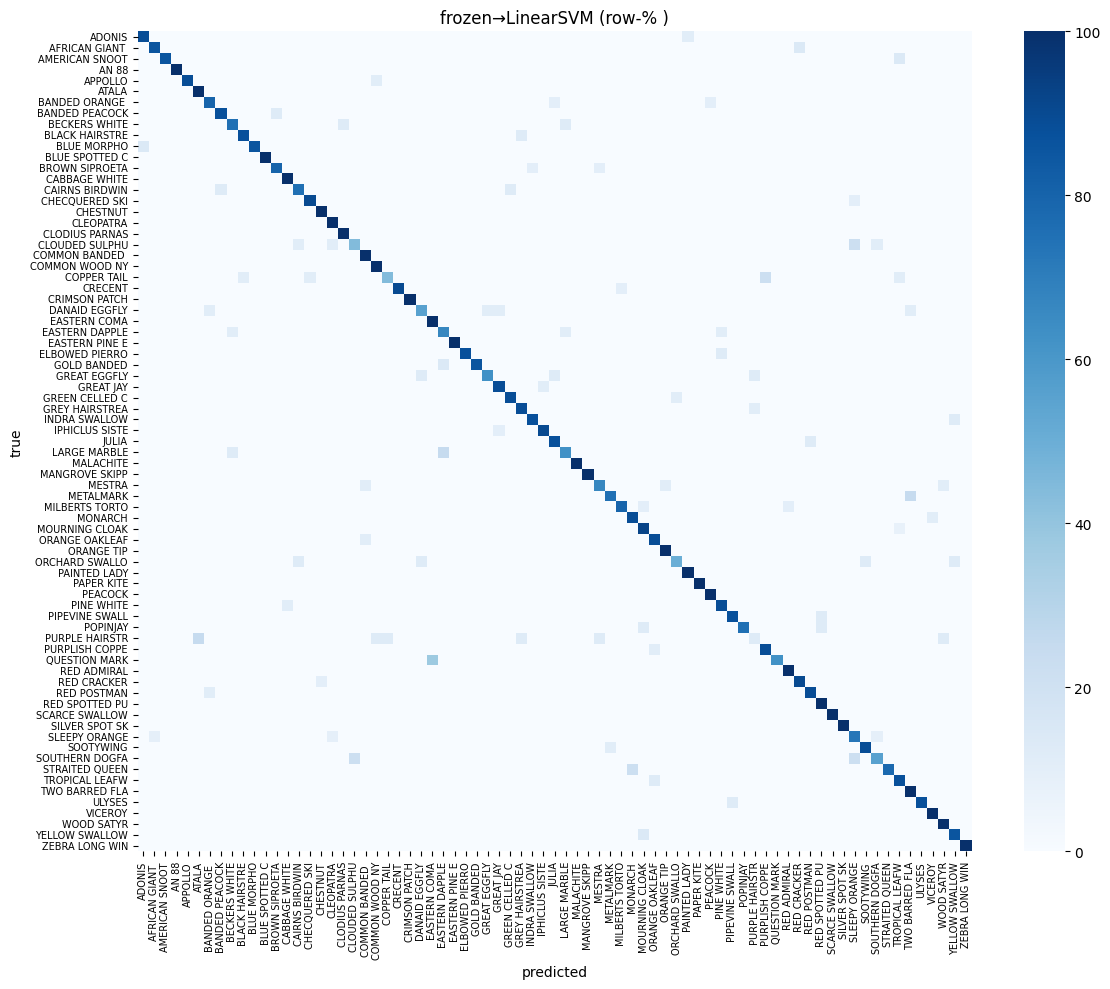

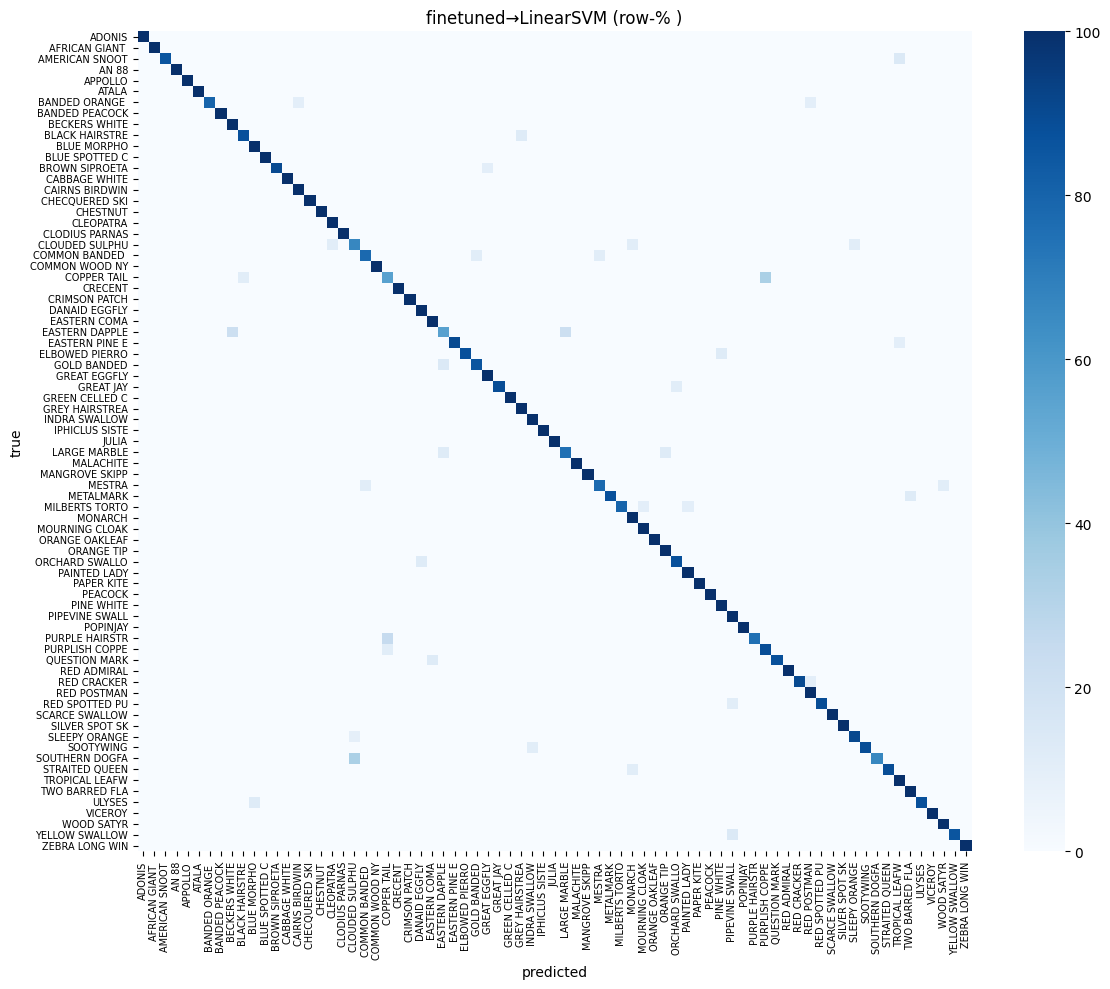

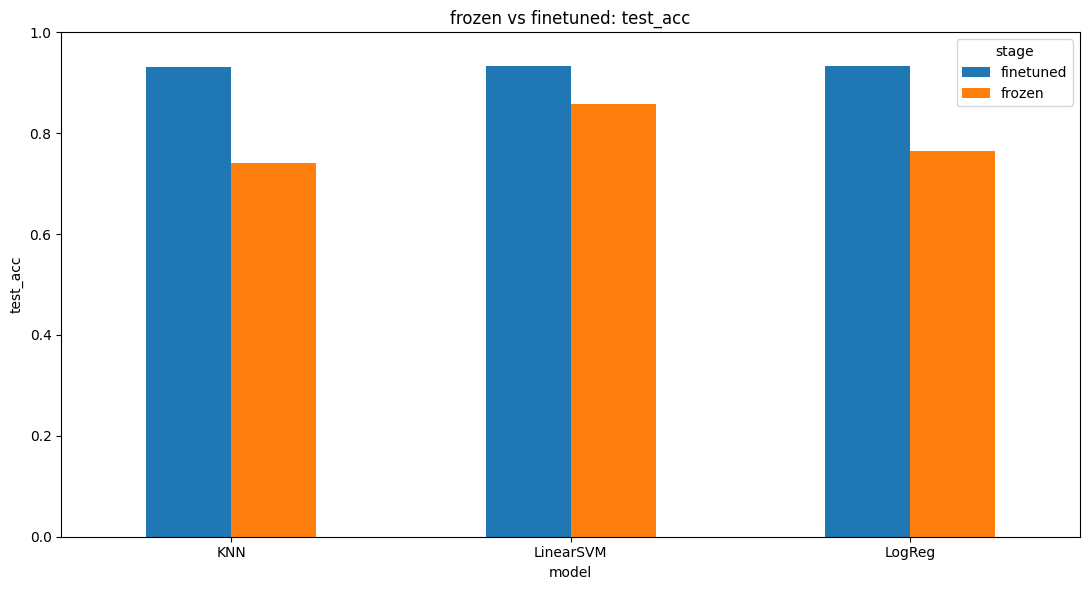

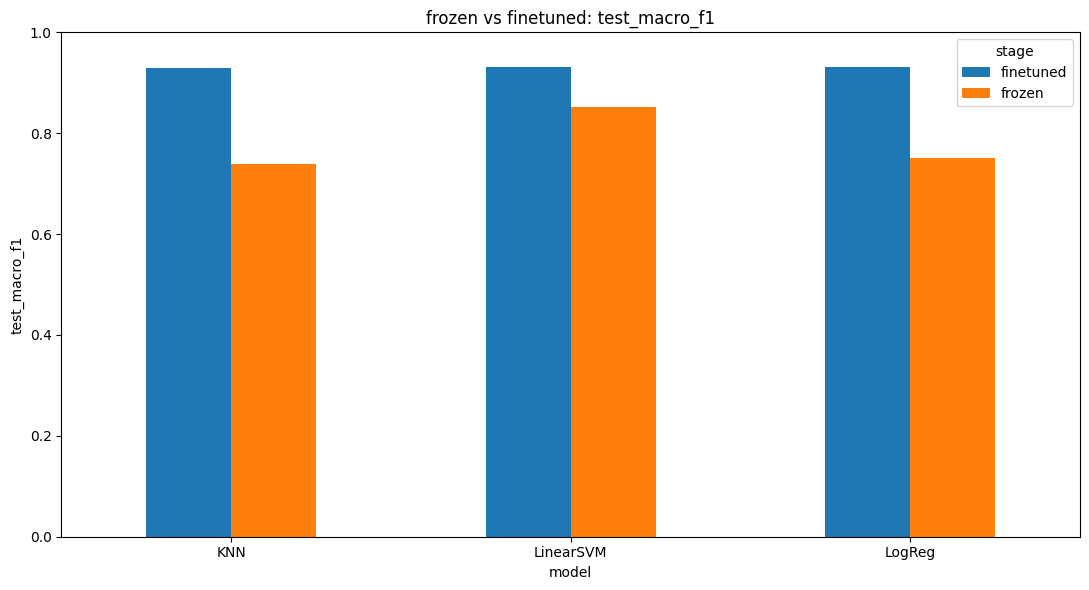

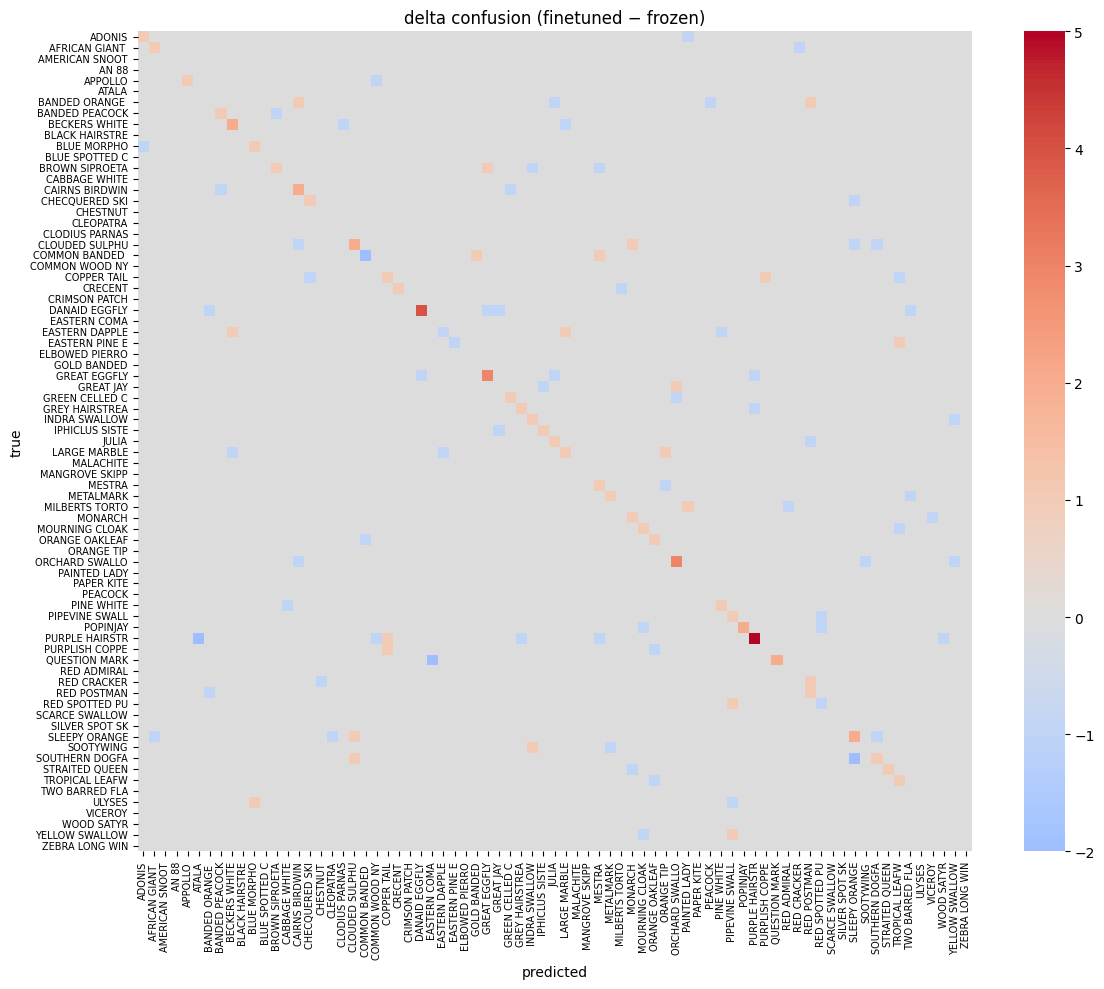

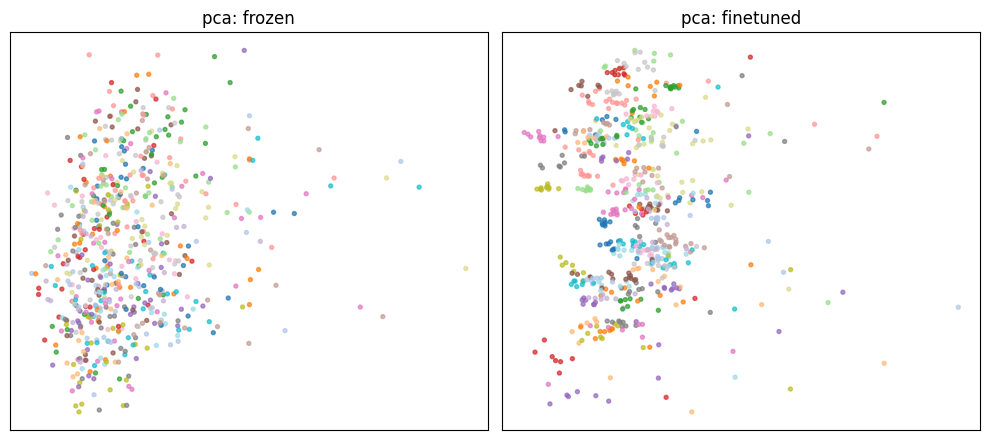

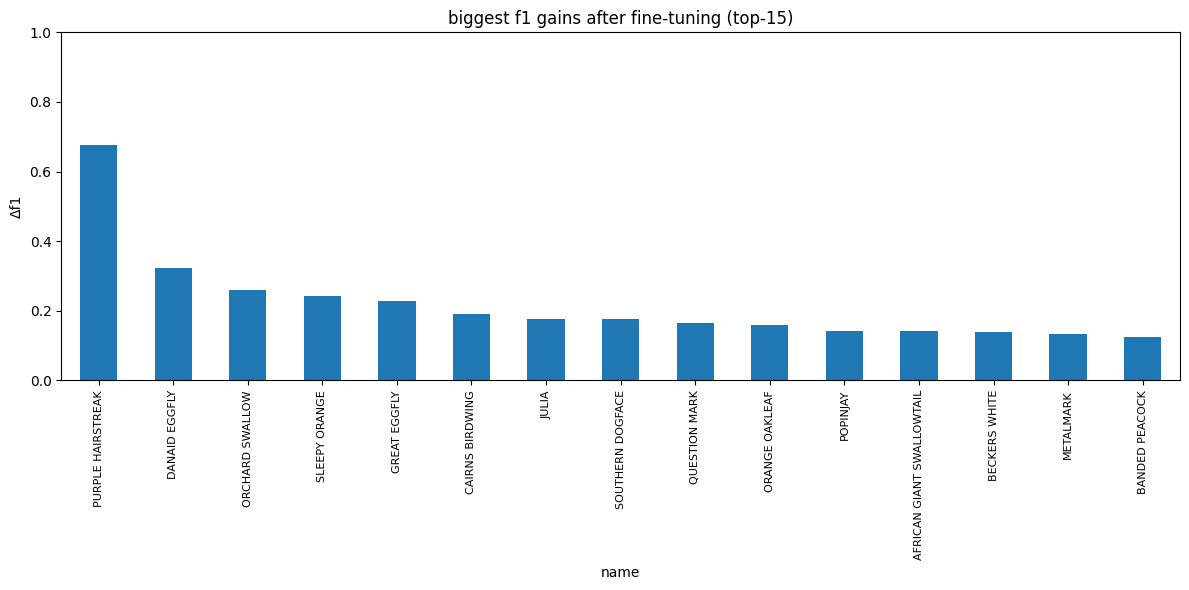

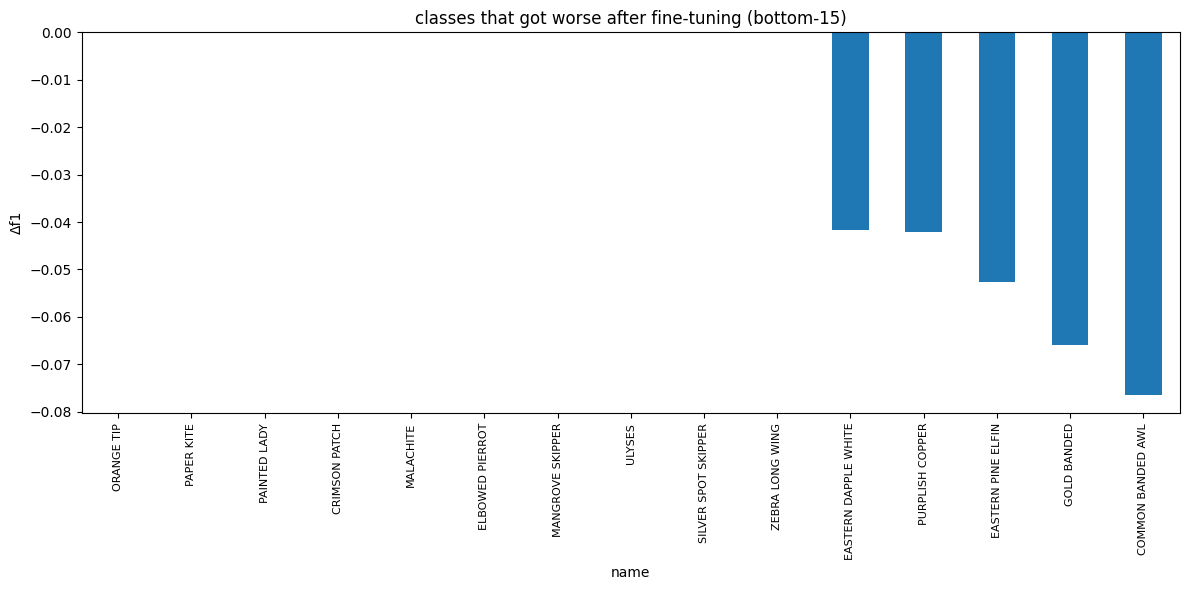

In [ ]:
# compare table
frozen_tbl = results_frozen.copy(); frozen_tbl["stage"] = "frozen"
ft_tbl = results_ft.copy(); ft_tbl["stage"] = "finetuned"
compare_df = pd.concat([frozen_tbl, ft_tbl], axis=0, ignore_index=True)
print(compare_df.sort_values(["model","stage"]).reset_index(drop=True))

# normalized cms
def normalize_cm(cm):
    with np.errstate(divide="ignore", invalid="ignore"):
        rs = cm.sum(axis=1, keepdims=True)
        return np.divide(cm, rs, where=rs!=0)

plot_cm((normalize_cm(cm_frozen)*100).round(1), class_names, title=f"frozen→{best_frozen_name} (row-% )")
plot_cm((normalize_cm(cm_ft)*100).round(1),     class_names, title=f"finetuned→{best_ft_name} (row-% )")

# stage comparison bars
def stage_bar(df, metric="test_acc"):
    pv = df.pivot_table(index="model", columns="stage", values=metric)
    ax = pv.plot(kind="bar", figsize=(11,6))
    plt.title(f"frozen vs finetuned: {metric}")
    plt.ylabel(metric);
    if metric != "train_secs": plt.ylim(0,1)
    plt.xticks(rotation=0); plt.tight_layout(); savefig(f"compare_{metric}.png"); plt.show()

stage_bar(compare_df, "test_acc")
stage_bar(compare_df, "test_macro_f1")

# delta confusion: where did errors shift?
delta_cm = cm_ft - cm_frozen
plt.figure(figsize=(12,10))
sns.heatmap(delta_cm, cmap="coolwarm", center=0,
            xticklabels=[abbr(s) for s in class_names],
            yticklabels=[abbr(s) for s in class_names])
plt.title("delta confusion (finetuned − frozen)")
plt.xlabel("predicted"); plt.ylabel("true")
plt.xticks(rotation=90, fontsize=7); plt.yticks(fontsize=7)
plt.tight_layout(); savefig("delta_confusion.png"); plt.show()

# geometry change: pca overlay (same components)
pca = PCA(n_components=2, random_state=RANDOM_STATE).fit(np.vstack([emb_test, emb_test_ft]))
Z_frozen = pca.transform(emb_test); Z_ft = pca.transform(emb_test_ft)

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.scatter(Z_frozen[:,0], Z_frozen[:,1], c=y_test_enc, s=8, alpha=0.7, cmap="tab20")
plt.title("pca: frozen"); plt.xticks([]); plt.yticks([])
plt.subplot(1,2,2)
plt.scatter(Z_ft[:,0], Z_ft[:,1], c=y_test_enc_ft, s=8, alpha=0.7, cmap="tab20")
plt.title("pca: finetuned"); plt.xticks([]); plt.yticks([])
plt.tight_layout(); savefig("pca_frozen_vs_ft.png"); plt.show()

# “hard classes”: which labels gained most f1?
def per_class_f1(df):
    sub = df.iloc[:-1][["precision","recall","f1-score"]].copy()
    sub["name"] = sub.index; return sub

pc_frozen = per_class_f1(rep_frozen).set_index("name")
pc_ft     = per_class_f1(rep_ft).set_index("name")
delta_f1  = (pc_ft["f1-score"] - pc_frozen["f1-score"]).sort_values(ascending=False)

plt.figure(figsize=(12,6))
delta_f1.head(15).plot(kind="bar")
plt.title("biggest f1 gains after fine-tuning (top-15)")
plt.ylabel("Δf1"); plt.ylim(min(0, delta_f1.head(15).min()-0.02), 1.0)
plt.xticks(rotation=90, fontsize=8); plt.tight_layout(); savefig("delta_f1_top15.png"); plt.show()

plt.figure(figsize=(12,6))
delta_f1.tail(15).plot(kind="bar")
plt.title("classes that got worse after fine-tuning (bottom-15)")
plt.ylabel("Δf1"); plt.xticks(rotation=90, fontsize=8)
plt.tight_layout(); savefig("delta_f1_bottom15.png"); plt.show()


# Discussion & Takeaways

## Why the SVM (baseline) struggled
**22.6% Accuracy**
- **Feature limitation:** Trained on raw pixels or simple features, the SVM had little notion of **spatial structure** (e.g., wing patterns, vein geometry). Without built-in invariances, small changes in pose/background hurt it.
- **Capacity vs. data:** With many classes and high-dimensional inputs, the SVM either **underfit** (linear kernel) or became brittle (nonlinear kernels) without a carefully engineered feature pipeline.
- **Dataset quirks:** Class imbalance and varied backgrounds made margin finding noisy; regularization and kernel choices helped only marginally.

## Why the MLP didn’t reach strong results
**31.2% Accuracy**
- **No inductive bias for images:** Fully-connected layers treat every pixel independently, so they don’t exploit local textures/edges like a CNN would. This leads to **inefficient learning**.
- **Overfitting tendencies:** Large parameter counts vs. limited data → memorization. Even with dropout/weight decay/early stopping, validation performance plateaued well below the CNN.
- **Augmentations help less:** Without convolutional structure, common image augments don’t translate into robust spatial features as effectively.

## Why the CNN did much better
**60.7% Accuracy**
- **Right bias for the job:** Convolutions + pooling capture **local patterns** (spots, stripes) and provide **translation invariance**, which matches how species cues appear on butterfly wings.
- **Weight sharing = data efficiency:** Far fewer effective parameters than an MLP at the same input size, so the model generalizes better with limited data.
- **Augmentation synergy:** Flips, crops, color jitter, etc. create variations the CNN can exploit to learn texture/shape cues rather than background shortcuts.
- **What still capped it:** Limited training data, resolution constraints, and residual background leakage likely kept accuracy around ~60% instead of higher.

## Why CLIP **surpassed** them all (with fine-tuning doing the heavy lifting)  
**85.8% Accuracy — SVM on frozen CLIP embeddings**  
- **Internet-scale priors:** Pretrained image–text alignment gives **rich, transferable features** that already separate many species cues (pose, lighting, clutter) better than models trained from scratch.  
- **Language anchoring:** Class prompts act as **semantic anchors**, reducing confusion among visually similar classes.  
- **Linear head suffices:** A **linear SVM on fixed embeddings** is enough to beat CNNs, showing how good the base representation is.  

**93.2% Accuracy — SVM on embeddings from our *fine-tuned* CLIP**  
- **Targeted domain adaptation:** We **lightly fine-tuned CLIP** on our dataset (low LR, strong regularization, early stopping, selective unfreezing of higher vision blocks), then **re-embedded images and retrained the same SVM head**.  
- **Sharper feature geometry:** Fine-tuning made **intra-class clusters tighter** and **inter-class margins wider**, letting a linear SVM draw cleaner boundaries.  
- **Butterfly-specific cues:** The encoder shifted attention toward **wing venation, dorsal/ventral patterns, edge shapes**, and away from backgrounds—precisely where our classes differ.  
- **Better calibration & fewer near-misses:** Similar species that previously overlapped became **separable with larger margins**, improving top-1 without a more complex head.  

**Takeaway:** Standard CLIP gives strong features, but **fine-tuning CLIP—then refitting the same SVM on the updated embeddings—is what unlocked the jump from 85.8% to 93.2%**.  

## Bottom line
- **SVM** was a fair, fast baseline but lacked the representation power for this vision task.  
- **MLP** overfit and under-generalized due to missing spatial inductive bias.  
- **CNN** matched the data well and landed around **>50%**, showing the value of convolutional priors and augmentation.  
- **CLIP (+ fine-tuning)** leveraged vast prior knowledge and light domain adaptation to **outperform by a wide margin**.

## If we wanted to push further
- Increase image **resolution** and strengthen **augmentations** (RandAugment, MixUp/CutMix).
- **Class-balance** (reweighting, focal loss) and **background randomization** to reduce shortcuts.
- **Tune CLIP** more systematically (prompt engineering, better heads, selective layer unfreezing).
- Try **test-time augmentation** and **ensembles** of strong checkpoints.
- Further invesitage the **Grad-cam** heatmaps and what they represent, produce more images and dive into the reasults more.
